<a href="https://colab.research.google.com/github/AnosWill-Lucifer/Air_Pollution_Analysis_PRAC1/blob/main/PRAC_1_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Impot Required Library

In [33]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 79.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 101.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.9 MB/s eta 0:00:00


In [34]:
import pandas as pd
import streamlit as st
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import time
import joblib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import (r2_score,mean_squared_error,mean_absolute_error,mean_absolute_percentage_error)


## Task 01: Data Importing

#### Mount Google Drive

In [6]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Colab Notebooks/Programming_Data_Analysis'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/Programming_Data_Analysis


I have selected the following five monitoring stations for this project: Gucheng, Dongsi, Guanyuan, Shunyi, and Huairou. These sites were chosen to provide a diverse set of data from various regions of Beijing, including urban, suburban, and potentially rural areas.

This geographical diversity allows for a comprehensive analysis of air quality patterns across different environments. Additionally, these stations offer well-rounded datasets with minimal missing values, which is crucial for accurate data preprocessing and modeling.

#### Read 5 files and merge

In [7]:
files = ['PRSA_Data_Gucheng_20130301-20170228.csv',
         'PRSA_Data_Dongsi_20130301-20170228.csv',
         'PRSA_Data_Guanyuan_20130301-20170228.csv',
         'PRSA_Data_Shunyi_20130301-20170228.csv',
         'PRSA_Data_Huairou_20130301-20170228.csv']
# Loading the datasets
data = {name: pd.read_csv(name) for name in files}
# Mergeing the datasets by 'year', 'month', 'day', 'hour' (assuming common columns to merge on)
merged_data = pd.concat(data.values(), axis=0, ignore_index=True)
merged_data.columns = merged_data.columns.str.upper()
merged_data.to_csv('merged_data.csv', index=False)
merged_data.head()

NO  YEAR  MONTH  DAY  HOUR  PM2.5  PM10  SO2  NO2     CO    O3  TEMP  \
0   1  2013      3    1     0    6.0  18.0  5.0  NaN  800.0  88.0   0.1   
1   2  2013      3    1     1    6.0  15.0  5.0  NaN  800.0  88.0  -0.3   
2   3  2013      3    1     2    5.0  18.0  NaN  NaN  700.0  52.0  -0.7   
3   4  2013      3    1     3    6.0  20.0  6.0  NaN    NaN   NaN  -1.0   
4   5  2013      3    1     4    5.0  17.0  5.0  NaN  600.0  73.0  -1.3   

     PRES  DEWP  RAIN   WD  WSPM  STATION  
0  1021.1 -18.6   0.0   NW   4.4  Gucheng  
1  1021.5 -19.0   0.0   NW   4.0  Gucheng  
2  1021.5 -19.8   0.0  WNW   4.6  Gucheng  
3  1022.7 -21.2   0.0    W   2.8  Gucheng  
4  1023.0 -21.4   0.0  WNW   3.6  Gucheng

In [8]:
merged_data.tail()

NO  YEAR  MONTH  DAY  HOUR  PM2.5  PM10  SO2   NO2      CO    O3  \
175315  35060  2017      2   28    19   16.0  28.0  2.0  19.0   300.0  95.0   
175316  35061  2017      2   28    20   21.0  34.0  4.0  24.0   500.0  80.0   
175317  35062  2017      2   28    21   17.0  33.0  2.0  39.0   900.0  60.0   
175318  35063  2017      2   28    22   11.0  29.0  3.0  32.0  1400.0  69.0   
175319  35064  2017      2   28    23   11.0  20.0  2.0  27.0   400.0  77.0   

        TEMP    PRES  DEWP  RAIN   WD  WSPM  STATION  
175315   9.9  1008.6 -14.1   0.0  WNW   1.8  Huairou  
175316   9.5  1008.9 -14.4   0.0  SSW   1.3  Huairou  
175317   8.4  1009.3 -14.6   0.0   SE   1.5  Huairou  
175318   8.3  1009.5 -14.7   0.0  ENE   3.2  Huairou  
175319   6.7  1009.3 -13.6   0.0   NE   1.9  Huairou

#### Read the merged file

In [9]:
df = pd.read_csv('merged_data.csv')

## Task 02: (EDA)  Data Understanding

In [10]:
df.shape

(175320, 18)

In [11]:
df.columns

Index(['NO', 'YEAR', 'MONTH', 'DAY', 'HOUR', 'PM2.5', 'PM10', 'SO2', 'NO2',
       'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WD', 'WSPM', 'STATION'],
      dtype='object')

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175320 entries, 0 to 175319
Data columns (total 18 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   NO       175320 non-null  int64  
 1   YEAR     175320 non-null  int64  
 2   MONTH    175320 non-null  int64  
 3   DAY      175320 non-null  int64  
 4   HOUR     175320 non-null  int64  
 5   PM2.5    171442 non-null  float64
 6   PM10     172632 non-null  float64
 7   SO2      171400 non-null  float64
 8   NO2      169388 non-null  float64
 9   CO       165369 non-null  float64
 10  O3       170114 non-null  float64
 11  TEMP     175127 non-null  float64
 12  PRES     175126 non-null  float64
 13  DEWP     175122 non-null  float64
 14  RAIN     175131 non-null  float64
 15  WD       174217 non-null  object 
 16  WSPM     175157 non-null  float64
 17  STATION  175320 non-null  object 
dtypes: float64(11), int64(5), object(2)
memory usage: 24.1+ MB


In [13]:
df.isnull().sum()

NO            0
YEAR          0
MONTH         0
DAY           0
HOUR          0
PM2.5      3878
PM10       2688
SO2        3920
NO2        5932
CO         9951
O3         5206
TEMP        193
PRES        194
DEWP        198
RAIN        189
WD         1103
WSPM        163
STATION       0
dtype: int64

In [14]:
df.describe().T

count          mean           std        min      25%      50%  \
NO     175320.0  17532.500000  10122.133783     1.0000  8766.75  17532.5   
YEAR   175320.0   2014.662560      1.177200  2013.0000  2014.00   2015.0   
MONTH  175320.0      6.522930      3.448713     1.0000     4.00      7.0   
DAY    175320.0     15.729637      8.800117     1.0000     8.00     16.0   
HOUR   175320.0     11.500000      6.922206     0.0000     5.75     11.5   
PM2.5  171442.0     80.437255     80.931035     2.0000    21.00     56.0   
PM10   172632.0    105.722100     92.460389     2.0000    36.00     84.0   
SO2    171400.0     15.451688     21.460623     0.2856     2.00      7.0   
NO2    169388.0     48.862360     34.167762     1.0265    22.00     42.0   
CO     165369.0   1225.991068   1134.777647   100.0000   500.00    900.0   
O3     170114.0     57.150906     56.442517     0.2142    11.00     45.0   
TEMP   175127.0     13.390887     11.488618   -19.9000     3.00     14.4   
PRES   175126.0   1010.777415     10.422248   982.8000  1002.40   1010.4   
DEWP   175122.0      2.577018     13.815964   -43.4000    -8.90      3.2   
RAIN   175131.0      0.064986      0.830760     0.0000     0.00      0.0   
WSPM   175157.0      1.674463      1.238881     0.0000     0.90      1.4   

            75%      max  
NO     26298.25  35064.0  
YEAR    2016.00   2017.0  
MONTH     10.00     12.0  
DAY       23.00     31.0  
HOUR      17.25     23.0  
PM2.5    112.00    941.0  
PM10     148.00    999.0  
SO2       19.00    500.0  
NO2       69.00    276.0  
CO      1500.00  10000.0  
O3        81.00   1071.0  
TEMP      23.20     41.6  
PRES    1019.00   1042.8  
DEWP      15.30     29.1  
RAIN       0.00     72.5  
WSPM       2.10     12.9

In [15]:
df.describe(include=['object'])

WD  STATION
count   174217   175320
unique      16        5
top         NE  Gucheng
freq     17402    35064

## Task 02: (EDA)  Data Preprocessing

#### Missing Values Analysis

The purpose of this following code block is to measure the quality of the dataset quantitatively using missing values. It does this by calculating, for every column, how many entries there should be, how many of those entries are missing, and the corresponding percentage of missing values. This is useful because missing data can lead to biased analysis or error at later steps of modeling. Positioning the metrics in the shape of a gradient-colored sorted table enables one to readily choose columns with a majority missing values to require cleaning or imputation prior to further analysis.

<Figure size 1000x600 with 0 Axes>

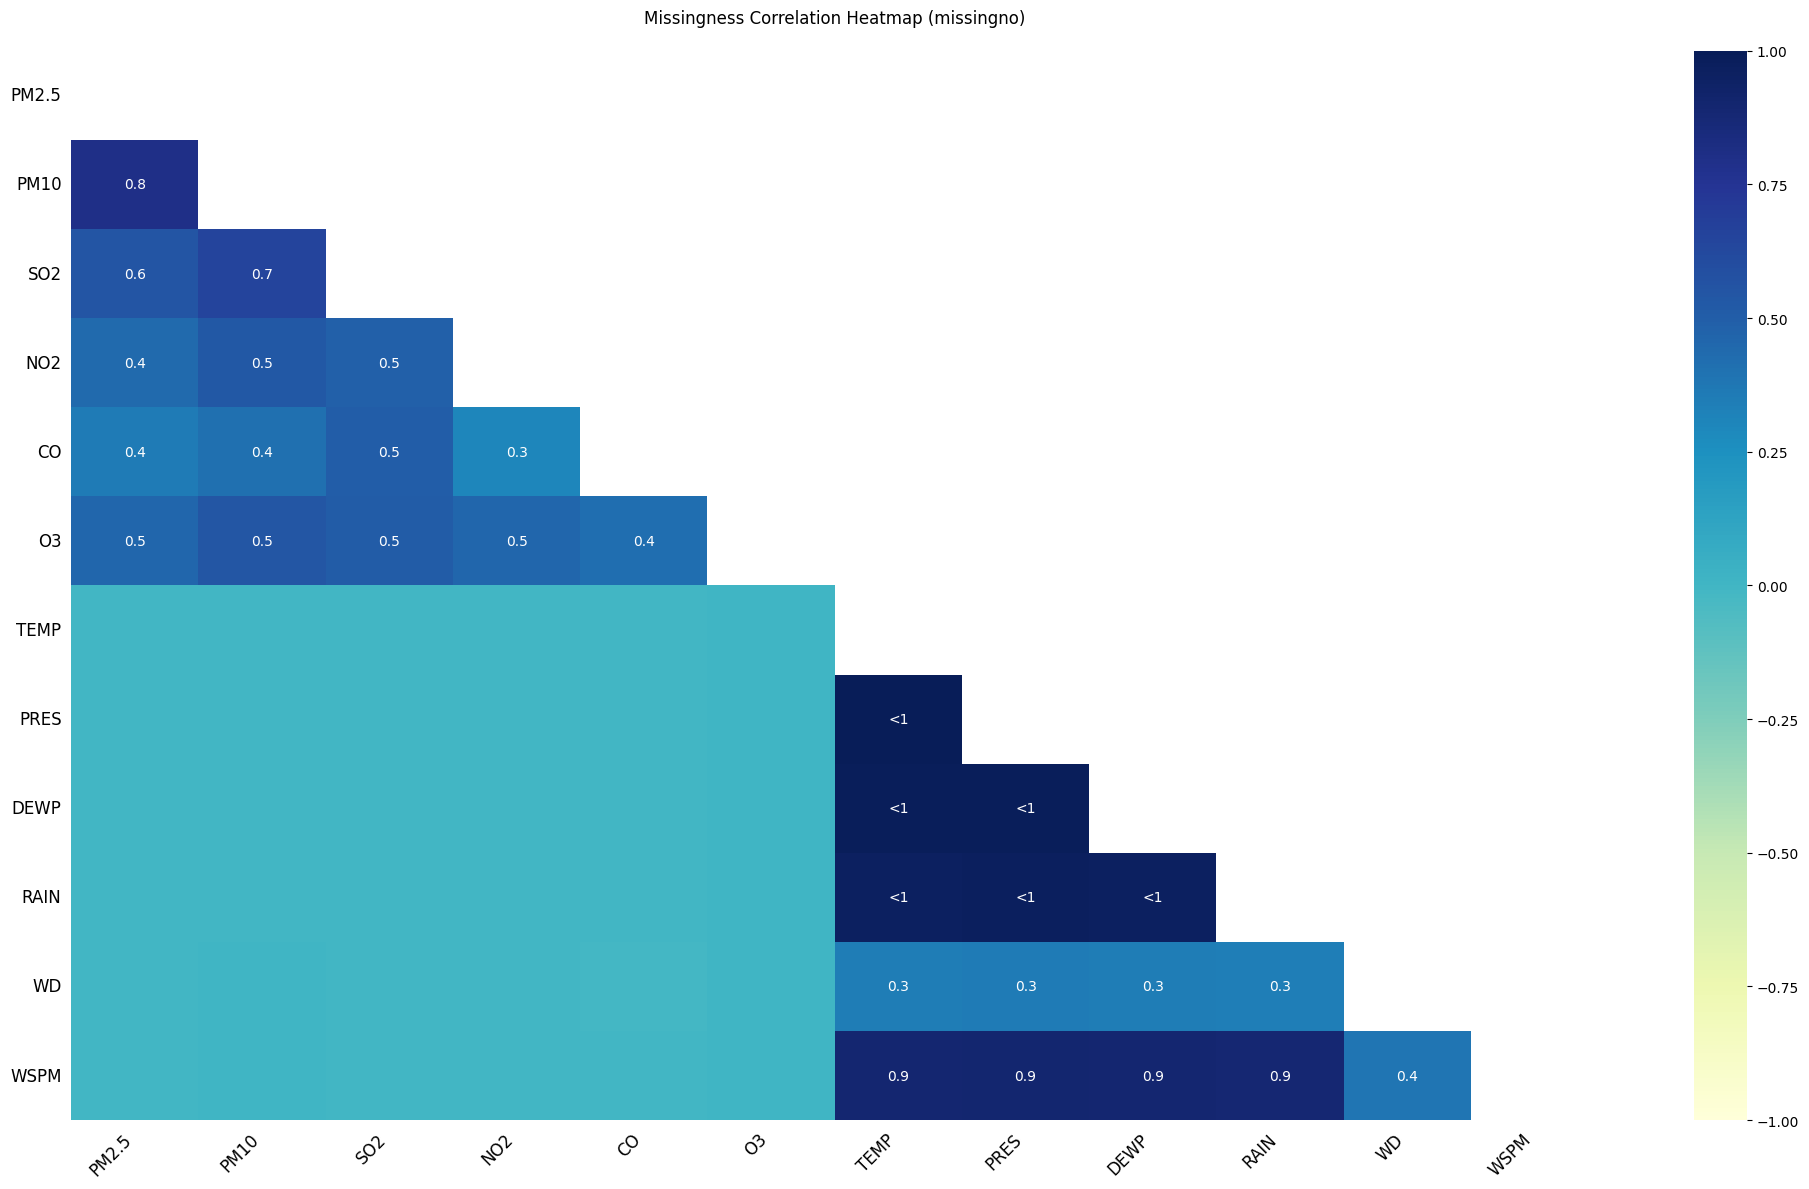

In [16]:
def missing_values_table(df):
    # Total number of values (rows) for each column
    total_values = pd.Series(df.shape[0], index=df.columns)
    # Number of missing values per column
    mis_val = df.isnull().sum()
    # Percentage of missing values per column
    mis_val_percent = 100 * mis_val / df.shape[0]
    # Combine into a single DataFrame
    mis_val_table = pd.concat([total_values, mis_val, mis_val_percent], axis=1)
    # Rename the columns
    mis_val_table = mis_val_table.rename(columns={0: 'Total Values',
                                                  1: 'Missing Values',
                                                  2: '% of Total Values'})
    # Sort the table by percentage of missing values in descending order
    mis_val_table = mis_val_table.sort_values('% of Total Values', ascending=False)
    return mis_val_table

missing_values = missing_values_table(merged_data)
display(missing_values.style.background_gradient(cmap='Oranges'))

plt.figure(figsize=(10, 6))
msno.heatmap(merged_data, cmap='YlGnBu', fontsize=12)
plt.title("Missingness Correlation Heatmap (missingno)", pad=20)
plt.tight_layout()
plt.show()

Nullity Correlation Heatmap (missingno)

The following heatmap, generated by `missingno.heatmap()`, is a visualization of the pairwise missingness correlation between our variables.
Denser colors indicate that two columns are often missing together.


Points of key insight from the plot:

*   PM2.5 & PM10 display very high co-missingness (~0.8), which means sensor failure tends to delete both measurements at once.
*   SO₂, NO₂, CO, and O₃ show moderate correlations (0.4–0.7) between themselves, again suggesting clustered pollutant dropouts.
*   Meteorological parameters (TEMP, PRES, DEWP, RAIN) exhibit almost all in the cyan range (near zero correlation), i.e., they do not frequently miss data or do so unrelated to pollutant sensors.

Observing these trends, we are confident that any imputation strategy should treat pollutant readings as a whole (e.g., multivariate strategy), while weather variables may be treated separately.











#### Missing Value Removed by Forward Imputation

In [17]:
# 1. Captured missing‑value summary before imputation
missing_before = missing_values_table(merged_data)
# 2. Performed forward linear interpolation to fill NaNs
imputed_data = merged_data.interpolate(method='linear',limit_direction='forward',axis=0)
# 3. Captured missing‑value summary after imputation
missing_after = missing_values_table(imputed_data)
# 4. Saved the imputed dataset
imputed_data.to_csv('merged_data_imputed.csv', index=False)
print("Imputed dataset saved to 'merged_data_imputed.csv'")
# 5. Built a comparative summary
comparison = pd.concat([
    missing_before.rename(columns={
        'Missing Values': 'Missing_Before',
        '% of Total Values': '%_Before'
    }),
    missing_after.rename(columns={
        'Missing Values': 'Missing_After',
        '% of Total Values': '%_After'
    })[['Missing_After','%_After']]
], axis=1)

print("\nMissing‑Value Comparison Before vs. After Imputation:")
display(comparison)

# 6. Compared descriptive stats
print("\nDescriptive statistics BEFORE imputation:")
display(merged_data.describe().T)
print("\nDescriptive statistics AFTER imputation:")
display(imputed_data.describe().T)

<ipython-input-17-c3074a0e1712>:4: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  imputed_data = merged_data.interpolate(method='linear',limit_direction='forward',axis=0)


Imputed dataset saved to 'merged_data_imputed.csv'

Missing‑Value Comparison Before vs. After Imputation:


Total Values  Missing_Before  %_Before  Missing_After   %_After
CO             175320            9951  5.675907              0  0.000000
NO2            175320            5932  3.383527             20  0.011408
O3             175320            5206  2.969427              0  0.000000
SO2            175320            3920  2.235911              0  0.000000
PM2.5          175320            3878  2.211955              0  0.000000
PM10           175320            2688  1.533196              0  0.000000
WD             175320            1103  0.629135           1103  0.629135
DEWP           175320             198  0.112936              0  0.000000
PRES           175320             194  0.110655              0  0.000000
TEMP           175320             193  0.110084              0  0.000000
RAIN           175320             189  0.107803              0  0.000000
WSPM           175320             163  0.092973              0  0.000000
YEAR           175320               0  0.000000              0  0.000000
NO             175320               0  0.000000              0  0.000000
DAY            175320               0  0.000000              0  0.000000
MONTH          175320               0  0.000000              0  0.000000
HOUR           175320               0  0.000000              0  0.000000
STATION        175320               0  0.000000              0  0.000000


Descriptive statistics BEFORE imputation:


count          mean           std        min      25%      50%  \
NO     175320.0  17532.500000  10122.133783     1.0000  8766.75  17532.5   
YEAR   175320.0   2014.662560      1.177200  2013.0000  2014.00   2015.0   
MONTH  175320.0      6.522930      3.448713     1.0000     4.00      7.0   
DAY    175320.0     15.729637      8.800117     1.0000     8.00     16.0   
HOUR   175320.0     11.500000      6.922206     0.0000     5.75     11.5   
PM2.5  171442.0     80.437255     80.931035     2.0000    21.00     56.0   
PM10   172632.0    105.722100     92.460389     2.0000    36.00     84.0   
SO2    171400.0     15.451688     21.460623     0.2856     2.00      7.0   
NO2    169388.0     48.862360     34.167762     1.0265    22.00     42.0   
CO     165369.0   1225.991068   1134.777647   100.0000   500.00    900.0   
O3     170114.0     57.150906     56.442517     0.2142    11.00     45.0   
TEMP   175127.0     13.390887     11.488618   -19.9000     3.00     14.4   
PRES   175126.0   1010.777415     10.422248   982.8000  1002.40   1010.4   
DEWP   175122.0      2.577018     13.815964   -43.4000    -8.90      3.2   
RAIN   175131.0      0.064986      0.830760     0.0000     0.00      0.0   
WSPM   175157.0      1.674463      1.238881     0.0000     0.90      1.4   

            75%      max  
NO     26298.25  35064.0  
YEAR    2016.00   2017.0  
MONTH     10.00     12.0  
DAY       23.00     31.0  
HOUR      17.25     23.0  
PM2.5    112.00    941.0  
PM10     148.00    999.0  
SO2       19.00    500.0  
NO2       69.00    276.0  
CO      1500.00  10000.0  
O3        81.00   1071.0  
TEMP      23.20     41.6  
PRES    1019.00   1042.8  
DEWP      15.30     29.1  
RAIN       0.00     72.5  
WSPM       2.10     12.9


Descriptive statistics AFTER imputation:


count          mean           std        min      25%      50%  \
NO     175320.0  17532.500000  10122.133783     1.0000  8766.75  17532.5   
YEAR   175320.0   2014.662560      1.177200  2013.0000  2014.00   2015.0   
MONTH  175320.0      6.522930      3.448713     1.0000     4.00      7.0   
DAY    175320.0     15.729637      8.800117     1.0000     8.00     16.0   
HOUR   175320.0     11.500000      6.922206     0.0000     5.75     11.5   
PM2.5  175320.0     80.411255     80.938280     2.0000    21.00     56.0   
PM10   175320.0    106.135228     93.294820     2.0000    36.00     84.0   
SO2    175320.0     15.542785     21.946135     0.2856     2.00      7.0   
NO2    175300.0     48.822331     34.216735     1.0265    22.00     42.0   
CO     175320.0   1229.183336   1129.626627   100.0000   500.00    900.0   
O3     175320.0     57.121697     56.647927     0.2142    11.00     44.0   
TEMP   175320.0     13.382315     11.490648   -19.9000     3.00     14.4   
PRES   175320.0   1010.784693     10.422890   982.8000  1002.40   1010.4   
DEWP   175320.0      2.567071     13.820709   -43.4000    -8.90      3.1   
RAIN   175320.0      0.064940      0.830343     0.0000     0.00      0.0   
WSPM   175320.0      1.674723      1.239037     0.0000     0.90      1.4   

            75%      max  
NO     26298.25  35064.0  
YEAR    2016.00   2017.0  
MONTH     10.00     12.0  
DAY       23.00     31.0  
HOUR      17.25     23.0  
PM2.5    112.00    941.0  
PM10     148.00    999.0  
SO2       19.00    500.0  
NO2       69.00    276.0  
CO      1500.00  10000.0  
O3        81.00   1071.0  
TEMP      23.10     41.6  
PRES    1019.00   1042.8  
DEWP      15.30     29.1  
RAIN       0.00     72.5  
WSPM       2.10     12.9

#### Removing left over NAN and Duplicate values

In [18]:
# 1. Droping any rows still containing NaNs after interpolation and also the duplicate values
final_data = imputed_data.dropna()
final_data = final_data.drop_duplicates()

# 2. Calculated row counts before and after dropping
rows_before = imputed_data.shape[0]
rows_after  = final_data.shape[0]
removed     = rows_before - rows_after
pct_removed = removed / rows_before * 100

print(f"Rows before drop: {rows_before}")
print(f"Rows after drop:  {rows_after}")
print(f"Rows removed:     {removed} ({pct_removed:.2f}%)\n")

# 3. Verified that no missing values remain
missing_final = missing_values_table(final_data)
display(missing_final.style.background_gradient(cmap='Oranges'))

# 4. Saved the cleaned, final dataset
final_data.to_csv('merged_data_final.csv', index=False)
print("Final cleaned dataset saved to 'merged_data_final.csv'\n")

# 5. Quick descriptive‑stats comparison
print("Descriptive statistics — original vs. final:")
print("\nOriginal merged_data:")
display(merged_data.describe())

print("\nFinal_data (after drop):")
display(final_data.describe())


Rows before drop: 175320
Rows after drop:  174197
Rows removed:     1123 (0.64%)



Final cleaned dataset saved to 'merged_data_final.csv'

Descriptive statistics — original vs. final:

Original merged_data:


NO          YEAR          MONTH            DAY  \
count  175320.000000  175320.00000  175320.000000  175320.000000   
mean    17532.500000    2014.66256       6.522930      15.729637   
std     10122.133783       1.17720       3.448713       8.800117   
min         1.000000    2013.00000       1.000000       1.000000   
25%      8766.750000    2014.00000       4.000000       8.000000   
50%     17532.500000    2015.00000       7.000000      16.000000   
75%     26298.250000    2016.00000      10.000000      23.000000   
max     35064.000000    2017.00000      12.000000      31.000000   

                HOUR          PM2.5           PM10            SO2  \
count  175320.000000  171442.000000  172632.000000  171400.000000   
mean       11.500000      80.437255     105.722100      15.451688   
std         6.922206      80.931035      92.460389      21.460623   
min         0.000000       2.000000       2.000000       0.285600   
25%         5.750000      21.000000      36.000000       2.000000   
50%        11.500000      56.000000      84.000000       7.000000   
75%        17.250000     112.000000     148.000000      19.000000   
max        23.000000     941.000000     999.000000     500.000000   

                 NO2             CO             O3           TEMP  \
count  169388.000000  165369.000000  170114.000000  175127.000000   
mean       48.862360    1225.991068      57.150906      13.390887   
std        34.167762    1134.777647      56.442517      11.488618   
min         1.026500     100.000000       0.214200     -19.900000   
25%        22.000000     500.000000      11.000000       3.000000   
50%        42.000000     900.000000      45.000000      14.400000   
75%        69.000000    1500.000000      81.000000      23.200000   
max       276.000000   10000.000000    1071.000000      41.600000   

                PRES           DEWP           RAIN           WSPM  
count  175126.000000  175122.000000  175131.000000  175157.000000  
mean     1010.777415       2.577018       0.064986       1.674463  
std        10.422248      13.815964       0.830760       1.238881  
min       982.800000     -43.400000       0.000000       0.000000  
25%      1002.400000      -8.900000       0.000000       0.900000  
50%      1010.400000       3.200000       0.000000       1.400000  
75%      1019.000000      15.300000       0.000000       2.100000  
max      1042.800000      29.100000      72.500000      12.900000


Final_data (after drop):


NO           YEAR          MONTH            DAY  \
count  174197.000000  174197.000000  174197.000000  174197.000000   
mean    17474.360982    2014.655838       6.524326      15.722837   
std     10110.093907       1.175731       3.444333       8.800820   
min         1.000000    2013.000000       1.000000       1.000000   
25%      8718.000000    2014.000000       4.000000       8.000000   
50%     17456.000000    2015.000000       7.000000      16.000000   
75%     26229.000000    2016.000000      10.000000      23.000000   
max     35064.000000    2017.000000      12.000000      31.000000   

                HOUR         PM2.5           PM10            SO2  \
count  174197.000000  174197.00000  174197.000000  174197.000000   
mean       11.501501      80.26853     106.019648      15.557892   
std         6.914355      80.84729      93.208304      21.972885   
min         0.000000       2.00000       2.000000       0.285600   
25%         6.000000      21.00000      36.000000       2.000000   
50%        12.000000      56.00000      84.000000       7.000000   
75%        17.000000     112.00000     148.000000      19.000000   
max        23.000000     941.00000     999.000000     500.000000   

                 NO2             CO             O3           TEMP  \
count  174197.000000  174197.000000  174197.000000  174197.000000   
mean       48.743547    1226.401038      57.323413      13.423007   
std        34.180304    1126.730903      56.712555      11.489233   
min         1.026500     100.000000       0.214200     -19.900000   
25%        22.000000     500.000000      11.500650       3.000000   
50%        41.125000     900.000000      44.500000      14.400000   
75%        69.000000    1500.000000      81.610200      23.200000   
max       276.000000   10000.000000    1071.000000      41.600000   

                PRES           DEWP           RAIN           WSPM  
count  174197.000000  174197.000000  174197.000000  174197.000000  
mean     1010.757668       2.578597       0.065215       1.682499  
std        10.424060      13.826707       0.832892       1.236806  
min       982.800000     -36.000000       0.000000       0.000000  
25%      1002.300000      -8.900000       0.000000       0.900000  
50%      1010.400000       3.200000       0.000000       1.400000  
75%      1019.000000      15.300000       0.000000       2.100000  
max      1042.800000      29.100000      72.500000      12.900000

Final Cleaning and Verification

After interpolation, there were still some rows that contained NaNs (typically at the very start or end of each station's time series), so we dropped those rows to have a fully complete dataset.

• Rows before drop: 175,320

• Rows after drop:  174,197

• Rows removed:     1,123 (0.64%)

We re-ran our missing-value summary to ensure **no NaNs remain** in any column.
Means, minima, and maxima changed only very slightly in our "before vs. after" descriptive statistics comparison—showing that a very small proportion of unusable records was removed without biasing the data.

We saved the cleaned dataset ("merged_data_final.csv"), now gap‑free and ready for feature engineering and modeling.


#### Feature Engineering

##### Combines year, date, time into DATETIME

In [19]:
# 1. Made an explicit copy to avoid SettingWithCopyWarning
final_data = final_data.copy()
# 2. Created a proper datetime column from year, month, day, and hour
final_data.loc[:, 'DATETIME'] = pd.to_datetime( final_data[['YEAR', 'MONTH', 'DAY', 'HOUR']].assign(minute=0), format=None )
# 3. Set the new datetime column as the index and drop the original columns
final_data.set_index('DATETIME', inplace=True)
final_data.drop(columns=['YEAR', 'MONTH', 'DAY', 'HOUR'], inplace=True)
# 4. Verified the result
print("Index dtype:", final_data.index.dtype)

Index dtype: datetime64[ns]


In [20]:
final_data.head()

NO  PM2.5  PM10   SO2   NO2      CO    O3  TEMP    PRES  \
DATETIME                                                                       
2013-03-01 20:00:00  21   13.0  25.0  12.0   5.0  1100.0  61.0   1.6  1027.1   
2013-03-01 21:00:00  22   15.0  23.0  14.0  13.0  1200.0  52.0   1.0  1028.1   
2013-03-01 22:00:00  23   16.0  28.0  16.0  19.0  1200.0  45.0   1.3  1028.4   
2013-03-01 23:00:00  24   16.0  28.0  14.0  20.0  1100.0  44.0   0.2  1028.6   
2013-03-02 00:00:00  25   14.0  18.0  24.0  43.0  1399.0  25.0  -0.3  1028.9   

                     DEWP  RAIN   WD  WSPM  STATION  
DATETIME                                             
2013-03-01 20:00:00 -18.4   0.0  ESE   1.9  Gucheng  
2013-03-01 21:00:00 -17.4   0.0  SSE   0.7  Gucheng  
2013-03-01 22:00:00 -17.6   0.0    E   1.0  Gucheng  
2013-03-01 23:00:00 -17.6   0.0  ESE   1.1  Gucheng  
2013-03-02 00:00:00 -18.0   0.0  ENE   1.4  Gucheng

#####  **Air Quality Index (AQI) Calculation and Categorization**

> To transform raw hourly pollutant concentrations into a single, standardized AQI value and into a category. The U.S. EPA’s official methodology is used. Here’s how it works in detail:  
>  
> 1. **Breakpoint Tables (Clow, Chigh → Ilow, Ihigh)**  
>    - For each pollutant (PM₂.₅, PM₁₀, O₃, CO, SO₂, NO₂), the EPA defines several concentration intervals, e.g. for PM₂.₅:  
>      - 0.0–12.0 µg/m³ maps linearly to an AQI of 0–50  
>      - 12.1–35.4 µg/m³ maps to AQI 51–100 and so on up to 500 on the AQI scale.  
>    - In the code, each tuple `(Clow, Chigh, Ilow, Ihigh)` represents one of these brackets.  
>  
> 2. Sub‑Index Calculation  
>    - Given a measured concentration C, The bracket is located where `Clow ≤ C ≤ Chigh`.  
>    - The pollutant’s sub‑index I is calculated by linear interpolation:  
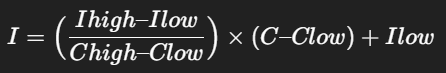

>    - This scales C gives proportionally within the AQI band defined by Ilow–Ihigh.  
>  
> 3. **Overall AQI Determination**  
>    - A sub‑index for each pollutant present in the row is calculated and the **maximum** of these values is taken.  
>    - Per EPA rules, the worst‑performing pollutant dictates the overall AQI (i.e., the “governing” index).  
>  
> 4. **AQI Category Assignment**  
>    - Once each row has a numeric AQI (0–500), it is bucketed it into one of six categories—Good, Moderate, Unhealthy for Sensitive Groups, Unhealthy, Very Unhealthy, Hazardous—using `pd.cut()` and the standard cut‑points (0–50, 51–100, etc.).  
>    - This produces an **AQI_Category** column that immediately tells whether the air quality at that hour was “Good,” “Moderate,” and so on.  
>  
> By structuring the code around these breakpoints and interpolation steps, it is ensured that AQI values and categories **exactly match** the EPA’s definitions.

In [21]:
# 1. Defined EPA‐style breakpoints for each pollutant
breakpoints = {
    'PM2.5': [
        (0.0,   12.0,   0,   50),
        (12.1,  35.4,  51,  100),
        (35.5,  55.4, 101,  150),
        (55.5, 150.4, 151,  200),
        (150.5,250.4, 201,  300),
        (250.5,350.4, 301,  400),
        (350.5,500.4, 401,  500),
    ],
    'PM10': [
        (0,    54,    0,   50),
        (55,  154,   51,  100),
        (155, 254,  101,  150),
        (255, 354,  151,  200),
        (355, 424,  201,  300),
        (425, 504,  301,  400),
        (505, 604,  401,  500),
    ],
    'O3': [
        (0.000, 0.054, 0,   50),
        (0.055, 0.070,51,  100),
        (0.071, 0.085,101, 150),
        (0.086, 0.105,151, 200),
        (0.106, 0.200,201, 300),
    ],
    'CO': [
        (0.0,   4.4,   0,   50),
        (4.5,   9.4,  51,  100),
        (9.5,  12.4, 101,  150),
        (12.5, 15.4, 151,  200),
        (15.5,30.4, 201,  300),
    ],
    'SO2': [
        (0,    35,    0,   50),
        (36,  75,    51,  100),
        (76,  185,  101,  150),
        (186, 304,  151,  200),
        (305, 604,  201,  300),
    ],
    'NO2': [
        (0,    53,    0,   50),
        (54,  100,   51,  100),
        (101, 360,  101,  150),
        (361, 649,  151,  200),
        (650,1249,  201,  300),
    ],
}
# 2. Function to compute individual pollutant AQI segment
def _aqi_segment(conc, bp_list):
    for Clow, Chigh, Ilow, Ihigh in bp_list:
        if Clow <= conc <= Chigh:
            return ((Ihigh - Ilow) / (Chigh - Clow)) * (conc - Clow) + Ilow
    return None
# 3. Function to compute overall AQI (max of sub‐indices)
def compute_aqi(row):
    sub_indices = []
    for pollutant, bps in breakpoints.items():
        conc = row[pollutant]
        sub = _aqi_segment(conc, bps)
        if sub is not None:
            sub_indices.append(sub)
    return max(sub_indices) if sub_indices else None
# 4. Applied to the DataFrame
final_data['AQI'] = final_data.apply(compute_aqi, axis=1)
# 5. Round AQI to integer and inspect
final_data['AQI'] = final_data['AQI'].round().astype(int)
# 6. Defined AQI categories based on EPA breakpoints
category_bins = [0, 50, 100, 150, 200, 300, 500]
category_labels = ['Good','Moderate','Unhealthy for Sensitive Groups','Unhealthy','Very Unhealthy','Hazardous']
# 7. Created the AQI_Category column
final_data['AQI_Category'] = pd.cut(final_data['AQI'],bins=category_bins,labels=category_labels,right=True,include_lowest=True)
# 8. Brought 'datetime' back as a column so it’s saved in the CSV
output_df = final_data.reset_index()
# 9. Overwritten the original merged CSV with the updated DataFrame
output_df.to_csv('merged_data_final.csv', index=False)
print("Updated CSV saved: 'merged_data_final.csv' now contains the datetime index, AQI, and AQI_Category columns.")



Updated CSV saved: 'merged_data_final.csv' now contains the datetime index, AQI, and AQI_Category columns.


In [22]:
final_data.head(100)

NO  PM2.5   PM10    SO2     NO2      CO    O3  TEMP  \
DATETIME                                                                    
2013-03-01 20:00:00   21   13.0   25.0   12.0    5.00  1100.0  61.0   1.6   
2013-03-01 21:00:00   22   15.0   23.0   14.0   13.00  1200.0  52.0   1.0   
2013-03-01 22:00:00   23   16.0   28.0   16.0   19.00  1200.0  45.0   1.3   
2013-03-01 23:00:00   24   16.0   28.0   14.0   20.00  1100.0  44.0   0.2   
2013-03-02 00:00:00   25   14.0   18.0   24.0   43.00  1399.0  25.0  -0.3   
...                  ...    ...    ...    ...     ...     ...   ...   ...   
2013-03-05 19:00:00  116  186.0  226.0   89.0  108.75   100.0  52.0   7.6   
2013-03-05 20:00:00  117  203.0  250.0   98.0  111.50   100.0  44.0   6.2   
2013-03-05 21:00:00  118  217.0  264.0  113.0  114.25   100.0  15.0   5.1   
2013-03-05 22:00:00  119  224.0  271.0  112.0  117.00   100.0  15.0   4.3   
2013-03-05 23:00:00  120  228.0  289.0  108.0  119.75   100.0  15.0   3.6   

                       PRES  DEWP  RAIN   WD  WSPM  STATION  AQI  \
DATETIME                                                           
2013-03-01 20:00:00  1027.1 -18.4   0.0  ESE   1.9  Gucheng   53   
2013-03-01 21:00:00  1028.1 -17.4   0.0  SSE   0.7  Gucheng   57   
2013-03-01 22:00:00  1028.4 -17.6   0.0    E   1.0  Gucheng   59   
2013-03-01 23:00:00  1028.6 -17.6   0.0  ESE   1.1  Gucheng   59   
2013-03-02 00:00:00  1028.9 -18.0   0.0  ENE   1.4  Gucheng   55   
...                     ...   ...   ...  ...   ...      ...  ...   
2013-03-05 19:00:00  1006.5  -6.2   0.0   SE   0.0  Gucheng  236   
2013-03-05 20:00:00  1006.9  -6.1   0.0    W   0.7  Gucheng  253   
2013-03-05 21:00:00  1007.0  -5.6   0.0  WNW   0.8  Gucheng  267   
2013-03-05 22:00:00  1006.8  -5.2   0.0  WNW   0.1  Gucheng  274   
2013-03-05 23:00:00  1006.5  -5.1   0.0    N   0.2  Gucheng  278   

                       AQI_Category  
DATETIME                             
2013-03-01 20:00:00        Moderate  
2013-03-01 21:00:00        Moderate  
2013-03-01 22:00:00        Moderate  
2013-03-01 23:00:00        Moderate  
2013-03-02 00:00:00        Moderate  
...                             ...  
2013-03-05 19:00:00  Very Unhealthy  
2013-03-05 20:00:00  Very Unhealthy  
2013-03-05 21:00:00  Very Unhealthy  
2013-03-05 22:00:00  Very Unhealthy  
2013-03-05 23:00:00  Very Unhealthy  

[100 rows x 16 columns]

##### Industrial, Vehicular Pollution and Seasons

In [23]:
# 1. Loaded the enriched dataset
df = pd.read_csv('merged_data_final.csv', parse_dates=['DATETIME'], index_col='DATETIME')
# 2. Grouped pollutants into two categories
vehicular   = ['PM2.5', 'PM10', 'NO2', 'CO']
industrial  = ['SO2', 'O3']
df['Vehicular_Pollution']  = df[vehicular].mean(axis=1)
df['Industrial_Pollution'] = df[industrial].mean(axis=1)
# 3. Added a 'season' column
season_map = {
    12:'Winter', 1:'Winter', 2:'Winter',
    3:'Spring', 4:'Spring', 5:'Spring',
    6:'Summer', 7:'Summer', 8:'Summer',
    9:'Autumn',10:'Autumn',11:'Autumn'
}
df['SEASONS'] = df.index.month.map(season_map)
df.to_csv('merged_data_final.csv')
df1 = pd.read_csv('merged_data_final.csv', parse_dates=['DATETIME'], index_col='DATETIME')
df1.head()

NO  PM2.5  PM10   SO2   NO2      CO    O3  TEMP    PRES  \
DATETIME                                                                       
2013-03-01 20:00:00  21   13.0  25.0  12.0   5.0  1100.0  61.0   1.6  1027.1   
2013-03-01 21:00:00  22   15.0  23.0  14.0  13.0  1200.0  52.0   1.0  1028.1   
2013-03-01 22:00:00  23   16.0  28.0  16.0  19.0  1200.0  45.0   1.3  1028.4   
2013-03-01 23:00:00  24   16.0  28.0  14.0  20.0  1100.0  44.0   0.2  1028.6   
2013-03-02 00:00:00  25   14.0  18.0  24.0  43.0  1399.0  25.0  -0.3  1028.9   

                     DEWP  RAIN   WD  WSPM  STATION  AQI AQI_Category  \
DATETIME                                                                
2013-03-01 20:00:00 -18.4   0.0  ESE   1.9  Gucheng   53     Moderate   
2013-03-01 21:00:00 -17.4   0.0  SSE   0.7  Gucheng   57     Moderate   
2013-03-01 22:00:00 -17.6   0.0    E   1.0  Gucheng   59     Moderate   
2013-03-01 23:00:00 -17.6   0.0  ESE   1.1  Gucheng   59     Moderate   
2013-03-02 00:00:00 -18.0   0.0  ENE   1.4  Gucheng   55     Moderate   

                     Vehicular_Pollution  Industrial_Pollution SEASONS  
DATETIME                                                                
2013-03-01 20:00:00               285.75                  36.5  Spring  
2013-03-01 21:00:00               312.75                  33.0  Spring  
2013-03-01 22:00:00               315.75                  30.5  Spring  
2013-03-01 23:00:00               291.00                  29.0  Spring  
2013-03-02 00:00:00               368.50                  24.5  Spring

#### Outliers and their removal

PM2.5: 1741 outliers (<1th pct or >99th pct) – 1.00% of data
PM10: 2161 outliers (<1th pct or >99th pct) – 1.24% of data
SO2: 2004 outliers (<1th pct or >99th pct) – 1.15% of data
NO2: 3242 outliers (<1th pct or >99th pct) – 1.86% of data
CO: 1741 outliers (<1th pct or >99th pct) – 1.00% of data
O3: 2032 outliers (<1th pct or >99th pct) – 1.17% of data
TEMP: 3424 outliers (<1th pct or >99th pct) – 1.97% of data
PRES: 3380 outliers (<1th pct or >99th pct) – 1.94% of data
DEWP: 3372 outliers (<1th pct or >99th pct) – 1.94% of data
RAIN: 1738 outliers (<1th pct or >99th pct) – 1.00% of data
WSPM: 1647 outliers (<1th pct or >99th pct) – 0.95% of data
AQI: 3434 outliers (<1th pct or >99th pct) – 1.97% of data
Vehicular_Pollution: 3478 outliers (<1th pct or >99th pct) – 2.00% of data
Industrial_Pollution: 2256 outliers (<1th pct or >99th pct) – 1.30% of data


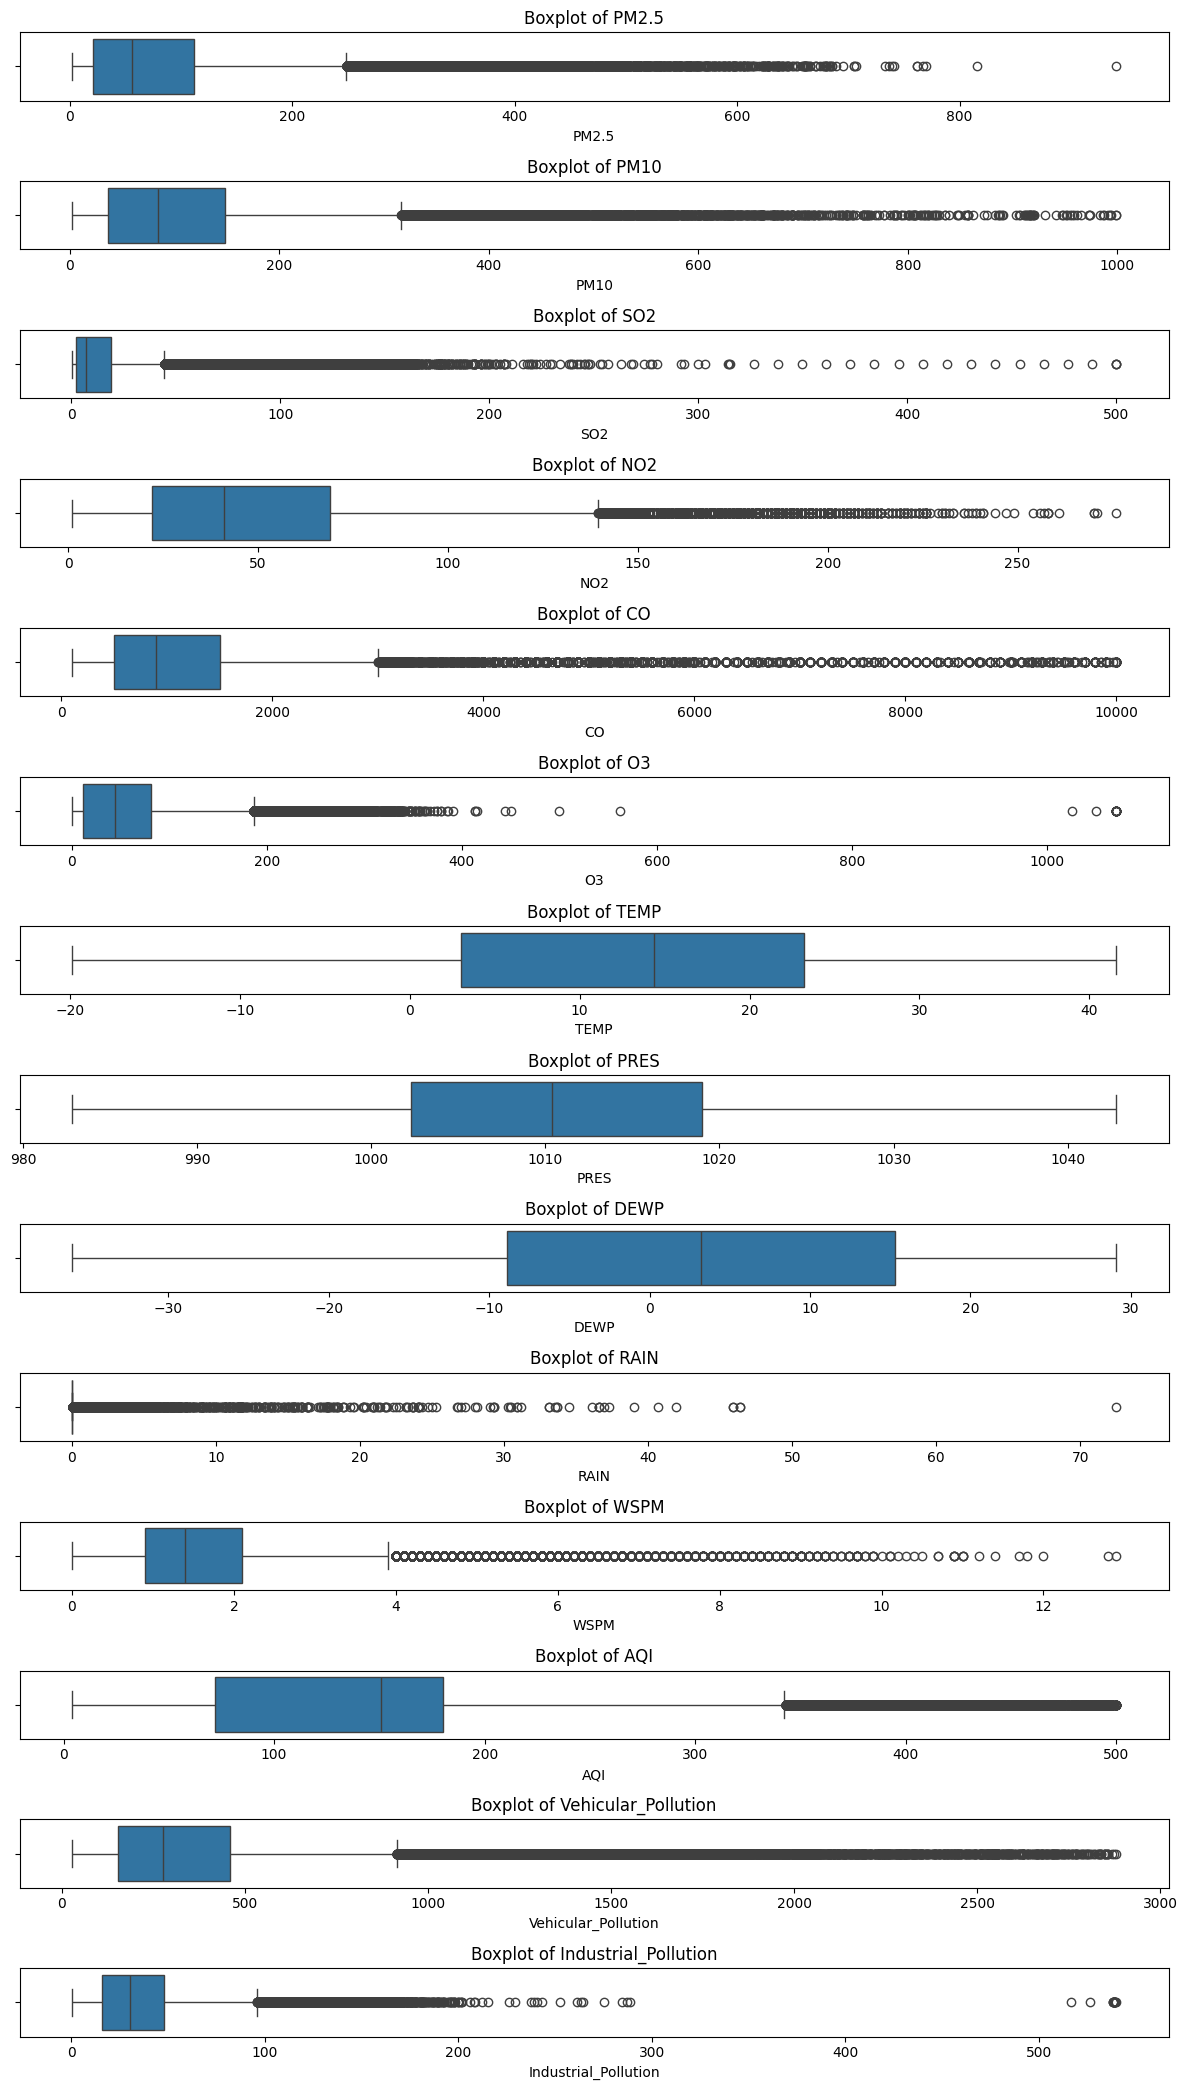


Rows before outlier removal: 174197
Rows after outlier removal:  150180
Total rows removed:          24017


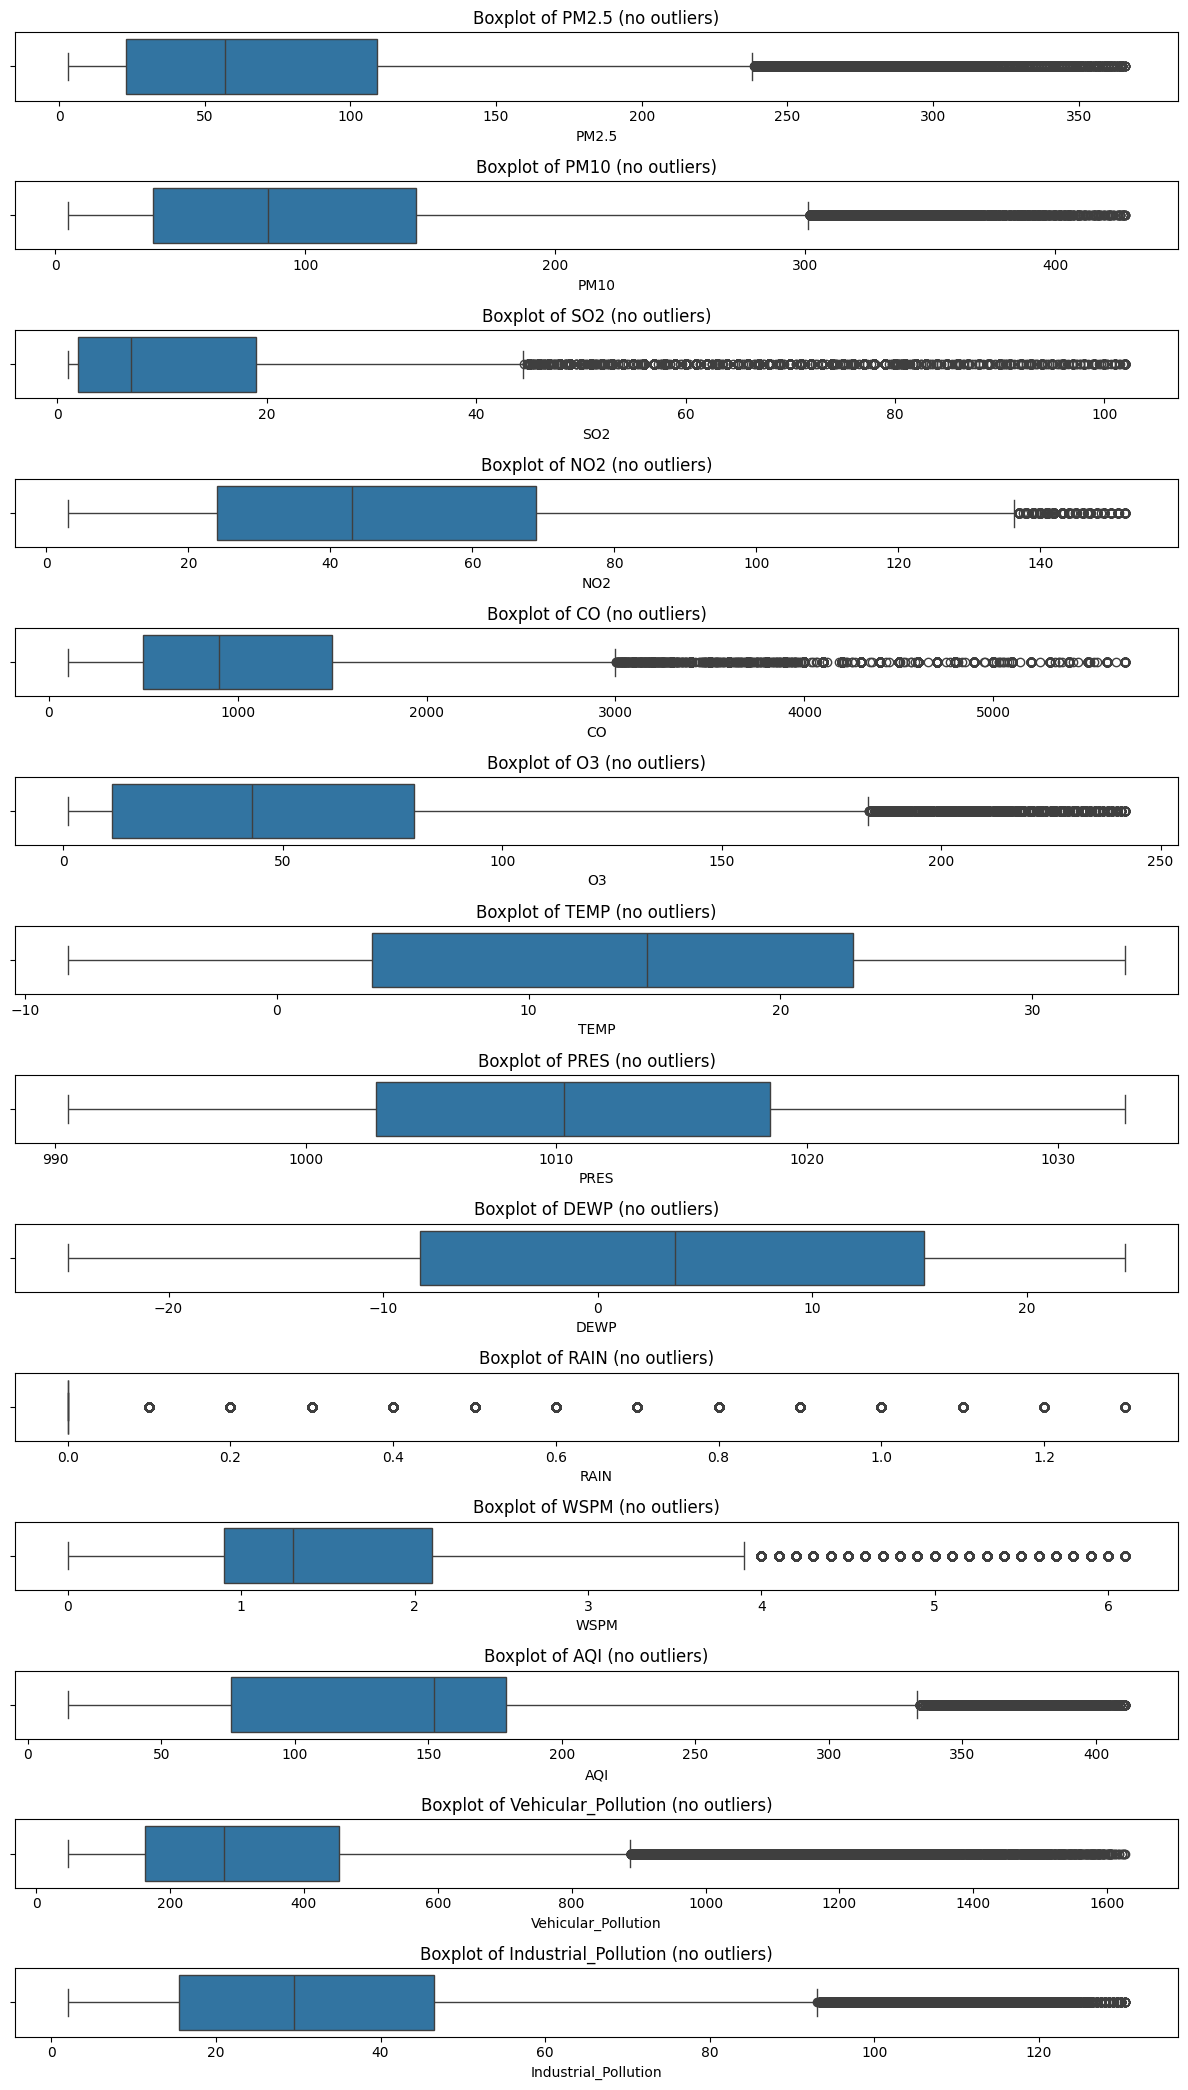

In [24]:
# 1. Loaded the enriched dataset
df = pd.read_csv('merged_data_final.csv', parse_dates=['DATETIME'], index_col='DATETIME')
# 2. Identifed numeric features (excluding code columns)
numeric_cols = df.select_dtypes(include='number').columns.drop(['NO'])
# 3. Outlier detection using winsorization‐style percentile bounds
outlier_info = {}
# Define lower and upper percentile thresholds (e.g. 1st and 99th percentiles)
lower_pct, upper_pct = 0.01, 0.99

for col in numeric_cols:
    lower = df[col].quantile(lower_pct)
    upper = df[col].quantile(upper_pct)
    mask = (df[col] < lower) | (df[col] > upper)
    outlier_count = mask.sum()
    outlier_info[col] = {
        'lower_pct': lower_pct, 'upper_pct': upper_pct,
        'lower_bound': lower, 'upper_bound': upper,
        'outliers': outlier_count
    }
    print(f"{col}: {outlier_count} outliers "
          f"(<{lower_pct*100:.0f}th pct or >{upper_pct*100:.0f}th pct) "
          f"– {outlier_count/len(df)*100:.2f}% of data")
# 4. Plot boxplots for each numeric feature (showing outliers)
plt.figure(figsize=(12, len(numeric_cols)*1.5))
for i, col in enumerate(numeric_cols, 1):
    ax = plt.subplot(len(numeric_cols), 1, i)
    sns.boxplot(x=df[col], ax=ax)
    ax.set_title(f"Boxplot of {col}")
plt.tight_layout()
plt.show()
# 5. Remove outliers: keep only rows within bounds for all features
df_clean = df.copy()
for col, info in outlier_info.items():
    df_clean = df_clean[
        (df_clean[col] >= info['lower_bound']) &
        (df_clean[col] <= info['upper_bound'])
    ]
print(f"\nRows before outlier removal: {len(df)}")
print(f"Rows after outlier removal:  {len(df_clean)}")
print(f"Total rows removed:          {len(df) - len(df_clean)}")
# 6. Saved the cleaned, outlier-free dataset
df_clean.to_csv('merged_data_no_outliers.csv')
# 7. Quick boxplots after removal to verify
plt.figure(figsize=(12, len(numeric_cols)*1.5))
for i, col in enumerate(numeric_cols, 1):
    ax = plt.subplot(len(numeric_cols), 1, i)
    sns.boxplot(x=df_clean[col], ax=ax)
    ax.set_title(f"Boxplot of {col} (no outliers)")
plt.tight_layout()
plt.show()

#### Removing any sign of NaN after Feature Engineering

In [25]:
df=pd.read_csv('merged_data_no_outliers.csv', parse_dates=['DATETIME'], index_col='DATETIME')
nan_count = df.isnull().sum().sum()  # Total NaN values in the DataFrame
print(f"Total NaN values after feature engineering: {nan_count}")
# Remove rows with NaN values
df_final = df.dropna()
# Saved the final cleaned dataset (overwriting the previous file)
df_final.to_csv('merged_data_no_outliers.csv')
print("Final cleaned dataset (with NaN values removed) saved to 'merged_data_no_outliers.csv'")

Total NaN values after feature engineering: 0
Final cleaned dataset (with NaN values removed) saved to 'merged_data_no_outliers.csv'


## Task 02: (EDA) Statistics/computation-based analysis and Visualisation:

#### Statistical Summary

In [26]:
# 1. Loaded the cleaned dataset
df = pd.read_csv('merged_data_no_outliers.csv', parse_dates=['DATETIME'], index_col='DATETIME')
display(df.head())
# 2. Columns to summarize
numeric_cols = ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3',
                'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM', 'AQI']
# 3. Standard describe() table
stats = df[numeric_cols].describe().T
# 4. Added more moments: median, skewness, and kurtosis
stats['median']   = df[numeric_cols].median()
stats['skew']     = df[numeric_cols].skew()
stats['kurtosis'] = df[numeric_cols].kurtosis()
print("=== Detailed Descriptive Statistics ===")
display(stats)
# 5. Showed how many hours fall into each AQI category
print("\n=== AQI Category Distribution ===")
display(df['AQI_Category'].value_counts().sort_index().to_frame(name='Count'))
# 6. Computed time-based summaries (numeric only)
yearly   = df.resample('YE').mean(numeric_only=True)   # year-end
monthly  = df.resample('ME').mean(numeric_only=True)   # month-end
weekly   = df.resample('W').mean(numeric_only=True)
daily    = df.resample('D').mean(numeric_only=True)
seasonal = df.groupby('SEASONS').mean(numeric_only=True)
# 7. Computed correlation matrices
corr_pollutants   = df[['PM2.5','PM10','SO2','NO2','CO','O3','AQI']].corr()
corr_vehicle_ind  = df[['Vehicular_Pollution','Industrial_Pollution']].corr()
# 8. Saved enriched DataFrame and summaries
df.to_csv('merged_data_eda.csv')
yearly.to_csv('yearly_summary.csv')
monthly.to_csv('monthly_summary.csv')
weekly.to_csv('weekly_summary.csv')
daily.to_csv('daily_summary.csv')
seasonal.to_csv('seasonal_summary.csv')

NO  PM2.5  PM10   SO2   NO2      CO    O3  TEMP    PRES  \
DATETIME                                                                       
2013-03-01 20:00:00  21   13.0  25.0  12.0   5.0  1100.0  61.0   1.6  1027.1   
2013-03-01 21:00:00  22   15.0  23.0  14.0  13.0  1200.0  52.0   1.0  1028.1   
2013-03-01 22:00:00  23   16.0  28.0  16.0  19.0  1200.0  45.0   1.3  1028.4   
2013-03-01 23:00:00  24   16.0  28.0  14.0  20.0  1100.0  44.0   0.2  1028.6   
2013-03-02 00:00:00  25   14.0  18.0  24.0  43.0  1399.0  25.0  -0.3  1028.9   

                     DEWP  RAIN   WD  WSPM  STATION  AQI AQI_Category  \
DATETIME                                                                
2013-03-01 20:00:00 -18.4   0.0  ESE   1.9  Gucheng   53     Moderate   
2013-03-01 21:00:00 -17.4   0.0  SSE   0.7  Gucheng   57     Moderate   
2013-03-01 22:00:00 -17.6   0.0    E   1.0  Gucheng   59     Moderate   
2013-03-01 23:00:00 -17.6   0.0  ESE   1.1  Gucheng   59     Moderate   
2013-03-02 00:00:00 -18.0   0.0  ENE   1.4  Gucheng   55     Moderate   

                     Vehicular_Pollution  Industrial_Pollution SEASONS  
DATETIME                                                                
2013-03-01 20:00:00               285.75                  36.5  Spring  
2013-03-01 21:00:00               312.75                  33.0  Spring  
2013-03-01 22:00:00               315.75                  30.5  Spring  
2013-03-01 23:00:00               291.00                  29.0  Spring  
2013-03-02 00:00:00               368.50                  24.5  Spring

=== Detailed Descriptive Statistics ===


count         mean         std    min     25%     50%          75%  \
PM2.5  150180.0    76.510330   68.011793    3.0    23.0    57.0   109.000000   
PM10   150180.0   101.161974   76.881570    5.0    39.0    85.0   144.083333   
SO2    150180.0    14.708256   18.022482    1.0     2.0     7.0    19.000000   
NO2    150180.0    48.929350   30.808596    3.0    24.0    43.0    69.000000   
CO     150180.0  1169.123933  901.440333  100.0   500.0   900.0  1500.000000   
O3     150180.0    54.495998   51.288825    1.0    11.0    43.0    80.000000   
TEMP   150180.0    13.586890   10.913286   -8.3     3.8    14.7    22.900000   
PRES   150180.0  1010.766359    9.827008  990.5  1002.8  1010.3  1018.500000   
DEWP   150180.0     2.947249   13.290972  -24.7    -8.3     3.6    15.200000   
RAIN   150180.0     0.013083    0.093989    0.0     0.0     0.0     0.000000   
WSPM   150180.0     1.600133    1.093949    0.0     0.9     1.3     2.100000   
AQI    150180.0   138.642955   72.280824   15.0    76.0   152.0   179.000000   

          max  median      skew   kurtosis  
PM2.5   366.0    57.0  1.356166   1.640253  
PM10    428.0    85.0  1.034205   0.800828  
SO2     102.0     7.0  2.048471   4.260504  
NO2     152.0    43.0  0.739364  -0.045729  
CO     5700.0   900.0  1.688943   3.305952  
O3      242.0    43.0  1.223603   1.169105  
TEMP     33.7    14.7 -0.141978  -1.182313  
PRES   1032.7  1010.3  0.126249  -0.908369  
DEWP     24.6     3.6 -0.177002  -1.200375  
RAIN      1.3     0.0  9.106064  91.984977  
WSPM      6.1     1.3  1.307610   1.910906  
AQI     411.0   152.0  0.559081   0.364317


=== AQI Category Distribution ===


Count
AQI_Category                         
Good                            17449
Hazardous                        4367
Moderate                        34925
Unhealthy                       55592
Unhealthy for Sensitive Groups  21207
Very Unhealthy                  16640

#### Graphical Visiualizations

=== Yearly Averages ===


NO      PM2.5        PM10        SO2        NO2  \
DATETIME                                                                
2013-12-31   3663.924732  76.448829  100.322844  18.580391  51.278428   
2014-12-31  11792.740506  80.690211  109.448887  18.049450  53.077770   
2015-12-31  20459.996985  77.199682   99.930602  12.266441  45.262683   
2016-12-31  29301.821540  71.020406   95.082896  10.063635  45.672610   
2017-12-31  34414.042584  80.931565   98.770986  18.925233  54.999786   

                     CO         O3       TEMP         PRES       DEWP  \
DATETIME                                                                
2013-12-31  1188.951885  54.011414  14.983282  1008.589049   5.084320   
2014-12-31  1213.831200  57.142457  14.038135  1010.420441   3.463595   
2015-12-31  1160.017449  55.316207  13.686983  1011.133687   3.279617   
2016-12-31  1086.299386  53.544900  13.752936  1011.005039   2.663661   
2017-12-31  1384.046133  39.575318   0.723801  1021.200092 -13.039160   

                RAIN      WSPM         AQI  Vehicular_Pollution  \
DATETIME                                                          
2013-12-31  0.013379  1.464775  139.789829           354.250496   
2014-12-31  0.009978  1.466120  143.871250           364.262017   
2015-12-31  0.017510  1.620525  138.886404           345.602604   
2016-12-31  0.012810  1.778169  132.535644           324.518825   
2017-12-31  0.004038  1.919108  136.346733           404.687118   

            Industrial_Pollution  
DATETIME                          
2013-12-31             36.295903  
2014-12-31             37.595954  
2015-12-31             33.791324  
2016-12-31             31.804267  
2017-12-31             29.250275


=== Seasonal Averages ===


NO      PM2.5        PM10        SO2        NO2  \
SEASONS                                                              
Autumn   18732.145864  81.434939  103.250957   9.855516  53.609910   
Spring   14383.182058  76.834894  118.430775  17.928828  49.372856   
Summer   16747.839776  65.028128   83.126644   5.485929  36.861769   
Winter   20757.909606  82.798332   98.333165  26.394637  55.983952   

                  CO         O3       TEMP         PRES       DEWP      RAIN  \
SEASONS                                                                        
Autumn   1225.431265  34.757283  13.165674  1013.872627   5.513770  0.018127   
Spring    988.713805  67.961622  14.769463  1008.651158  -0.017848  0.008885   
Summer    911.169012  85.090823  25.549772  1000.235257  18.144731  0.020961   
Winter   1586.345360  28.910715  -0.053835  1020.890417 -12.809885  0.003730   

             WSPM         AQI  Vehicular_Pollution  Industrial_Pollution  
SEASONS                                                                   
Autumn   1.332515  142.109392           365.931768             22.306399  
Spring   1.942796  142.622648           308.338083             42.945225  
Summer   1.399675  129.606934           274.046388             45.288376  
Winter   1.727335  139.806424           455.865202             27.652676


=== Correlation: Pollutants & AQI ===


PM2.5      PM10       SO2       NO2        CO        O3       AQI
PM2.5  1.000000  0.875844  0.467230  0.607572  0.735157 -0.124320  0.958658
PM10   0.875844  1.000000  0.455266  0.629430  0.653639 -0.089061  0.881937
SO2    0.467230  0.455266  1.000000  0.510912  0.573842 -0.161864  0.466262
NO2    0.607572  0.629430  0.510912  1.000000  0.659546 -0.473782  0.630946
CO     0.735157  0.653639  0.573842  0.659546  1.000000 -0.322578  0.718254
O3    -0.124320 -0.089061 -0.161864 -0.473782 -0.322578  1.000000 -0.106088
AQI    0.958658  0.881937  0.466262  0.630946  0.718254 -0.106088  1.000000


=== Correlation: Vehicular vs Industrial ===


Vehicular_Pollution  Industrial_Pollution
Vehicular_Pollution               1.00000              -0.10644
Industrial_Pollution             -0.10644               1.00000

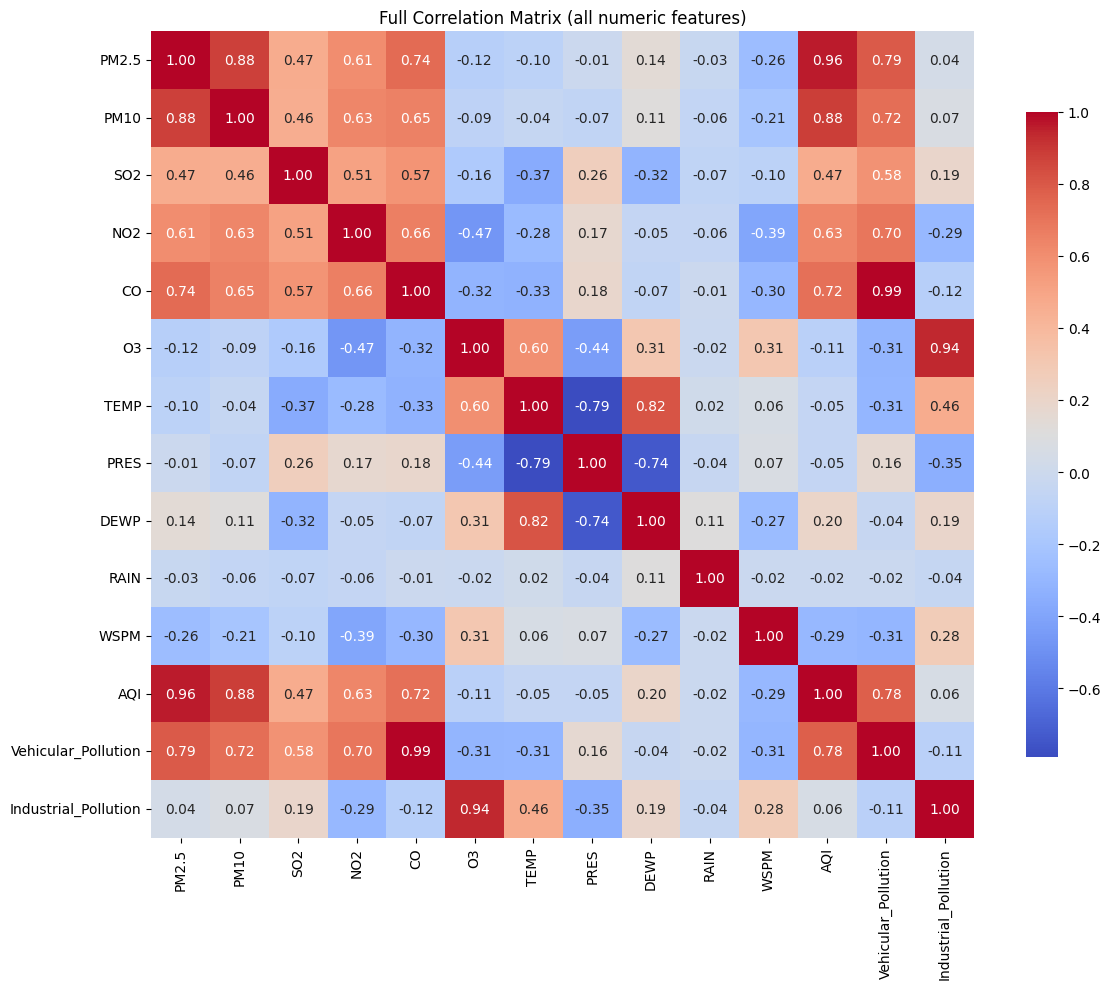

In [27]:
# 1. Display previews
print("=== Yearly Averages ===")
display(yearly.head())

print("\n=== Seasonal Averages ===")
display(seasonal)

print("\n=== Correlation: Pollutants & AQI ===")
display(corr_pollutants)

print("\n=== Correlation: Vehicular vs Industrial ===")
display(corr_vehicle_ind)

# 2. Full correlation matrix of all numeric features (excluding code cols)
numeric_cols = df.select_dtypes(include='number').columns.drop(['NO'])
corr_full = df[numeric_cols].corr()
corr_full.to_csv('full_correlation_matrix.csv')

plt.figure(figsize=(12,10))
sns.heatmap(
    corr_full,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    cbar_kws={'shrink': .8}
)
plt.title("Full Correlation Matrix (all numeric features)")
plt.tight_layout()
plt.show()


NO  PM2.5  PM10   SO2   NO2      CO    O3  TEMP    PRES  \
DATETIME                                                                       
2013-03-01 20:00:00  21   13.0  25.0  12.0   5.0  1100.0  61.0   1.6  1027.1   
2013-03-01 21:00:00  22   15.0  23.0  14.0  13.0  1200.0  52.0   1.0  1028.1   
2013-03-01 22:00:00  23   16.0  28.0  16.0  19.0  1200.0  45.0   1.3  1028.4   
2013-03-01 23:00:00  24   16.0  28.0  14.0  20.0  1100.0  44.0   0.2  1028.6   
2013-03-02 00:00:00  25   14.0  18.0  24.0  43.0  1399.0  25.0  -0.3  1028.9   

                     DEWP  RAIN   WD  WSPM  STATION  AQI AQI_Category  \
DATETIME                                                                
2013-03-01 20:00:00 -18.4   0.0  ESE   1.9  Gucheng   53     Moderate   
2013-03-01 21:00:00 -17.4   0.0  SSE   0.7  Gucheng   57     Moderate   
2013-03-01 22:00:00 -17.6   0.0    E   1.0  Gucheng   59     Moderate   
2013-03-01 23:00:00 -17.6   0.0  ESE   1.1  Gucheng   59     Moderate   
2013-03-02 00:00:00 -18.0   0.0  ENE   1.4  Gucheng   55     Moderate   

                     Vehicular_Pollution  Industrial_Pollution SEASONS  
DATETIME                                                                
2013-03-01 20:00:00               285.75                  36.5  Spring  
2013-03-01 21:00:00               312.75                  33.0  Spring  
2013-03-01 22:00:00               315.75                  30.5  Spring  
2013-03-01 23:00:00               291.00                  29.0  Spring  
2013-03-02 00:00:00               368.50                  24.5  Spring

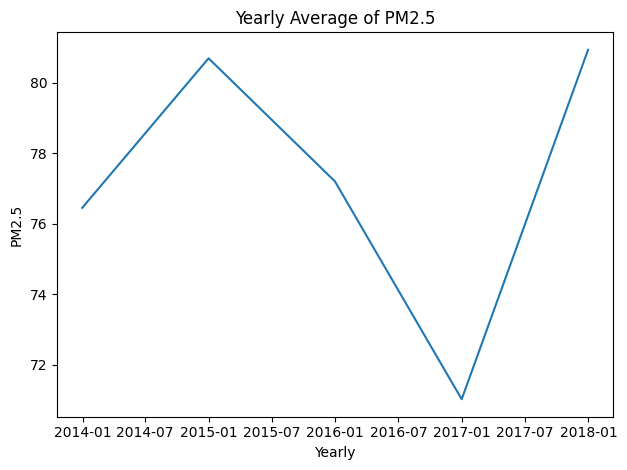

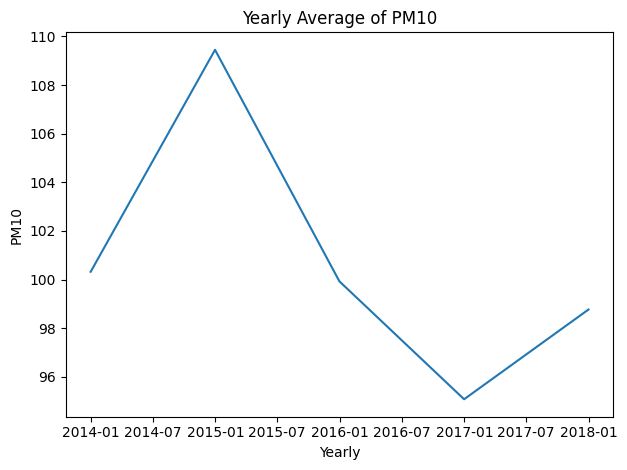

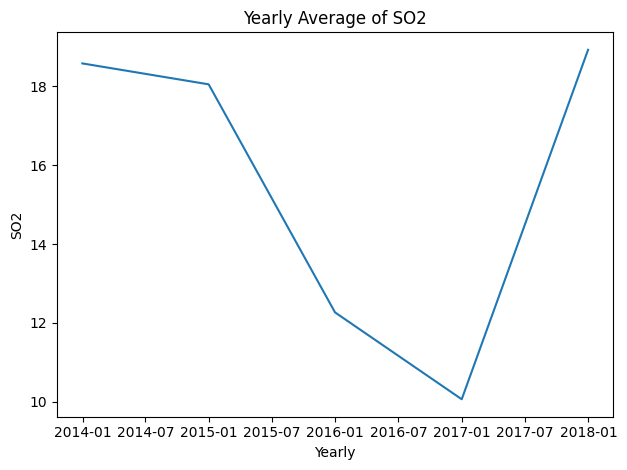

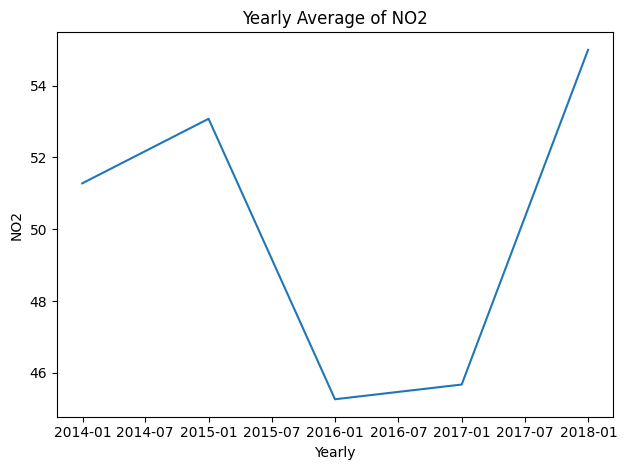

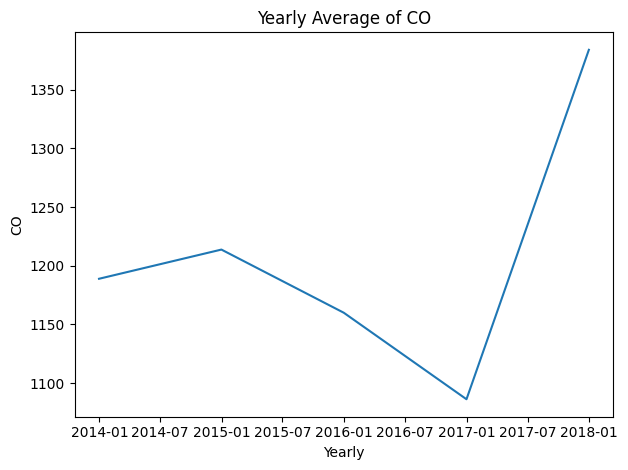

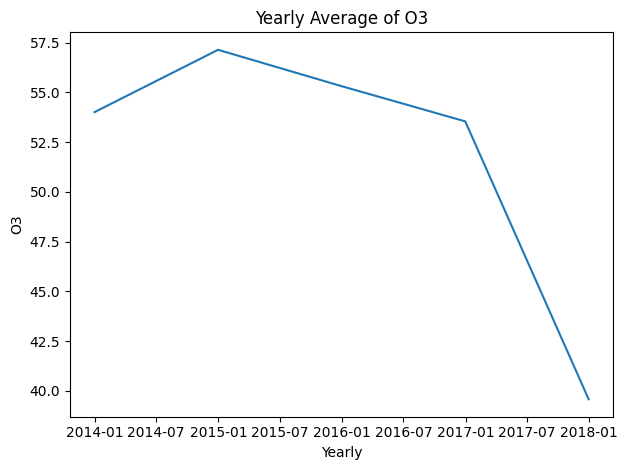

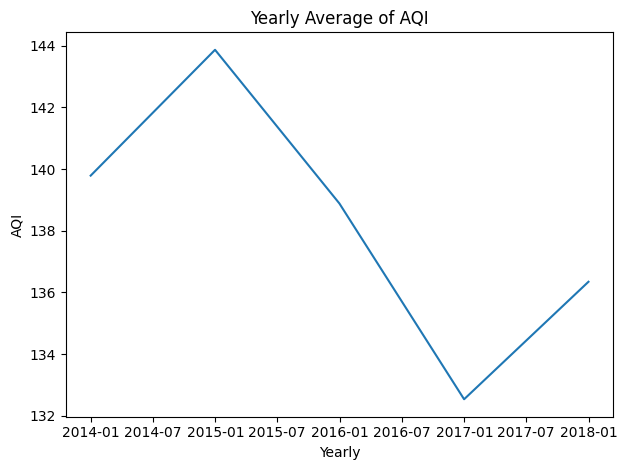

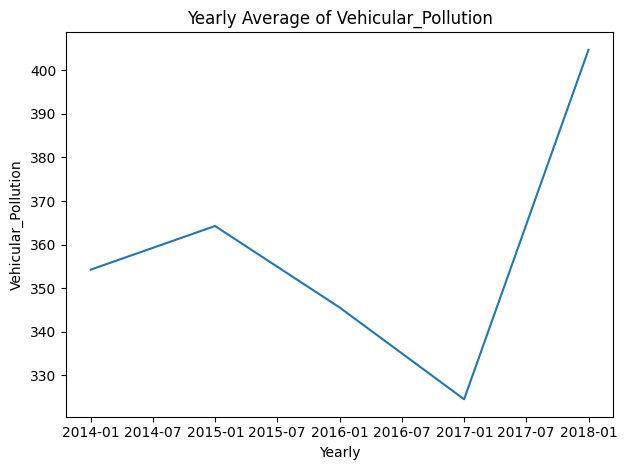

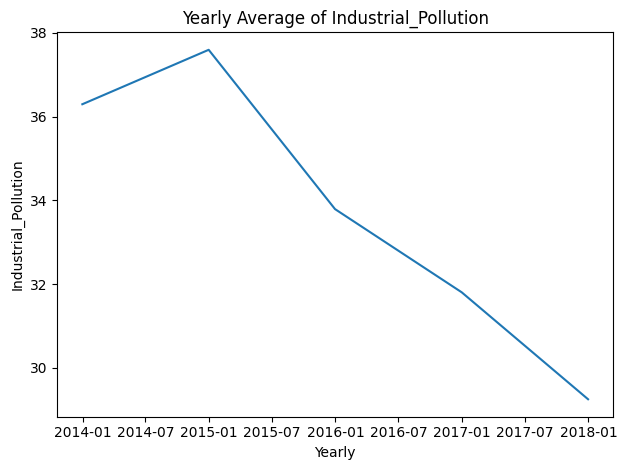

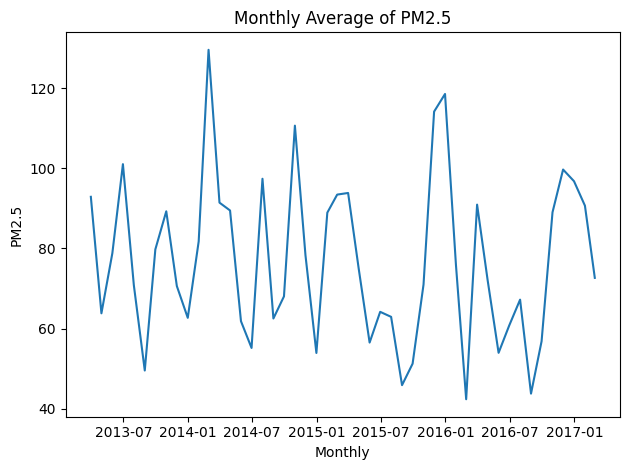

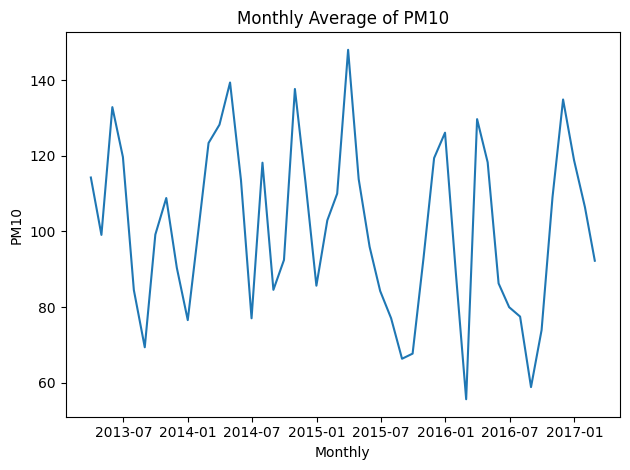

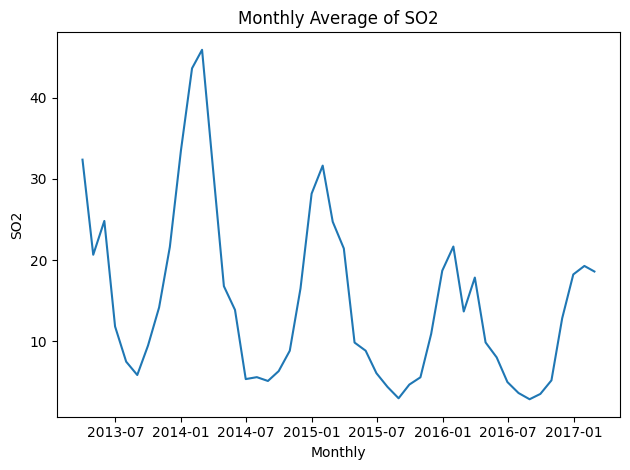

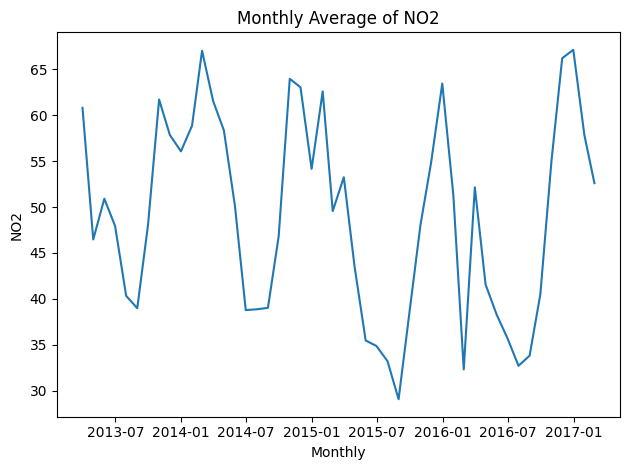

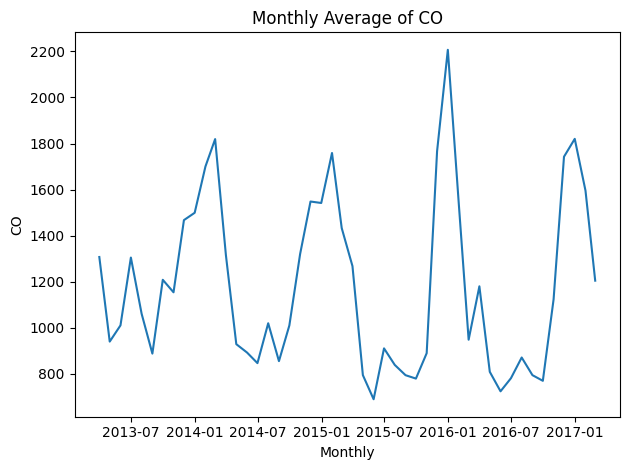

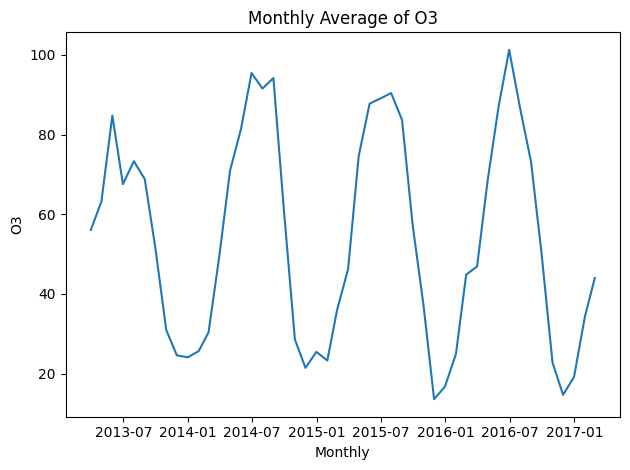

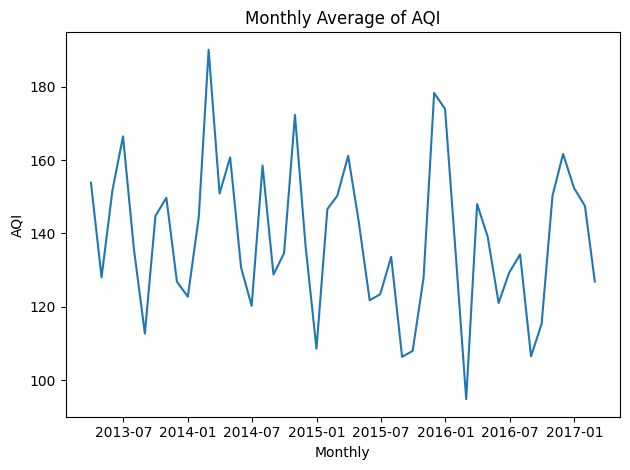

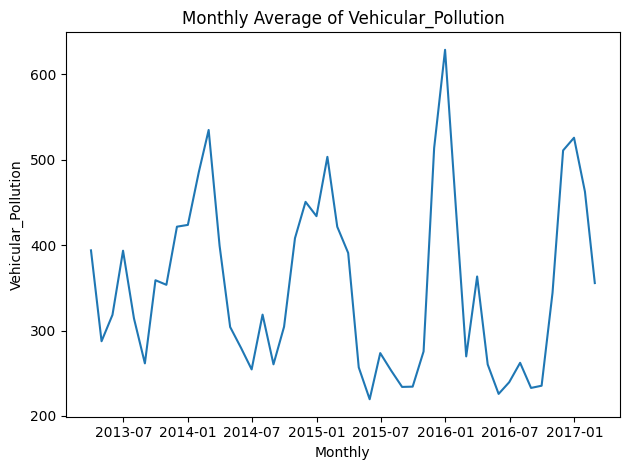

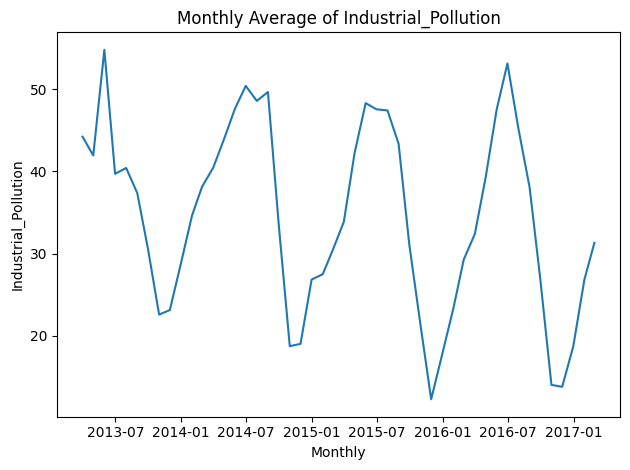

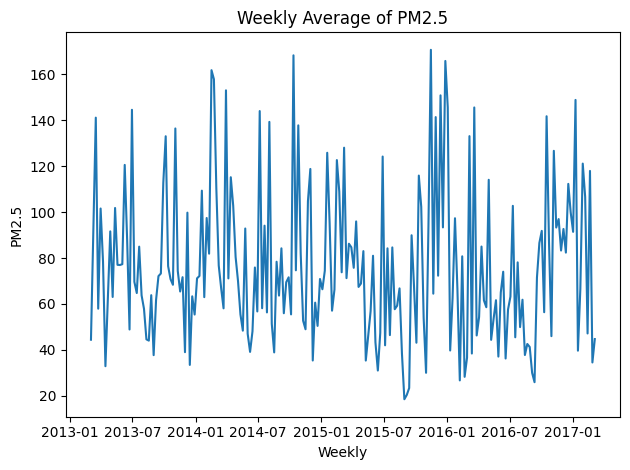

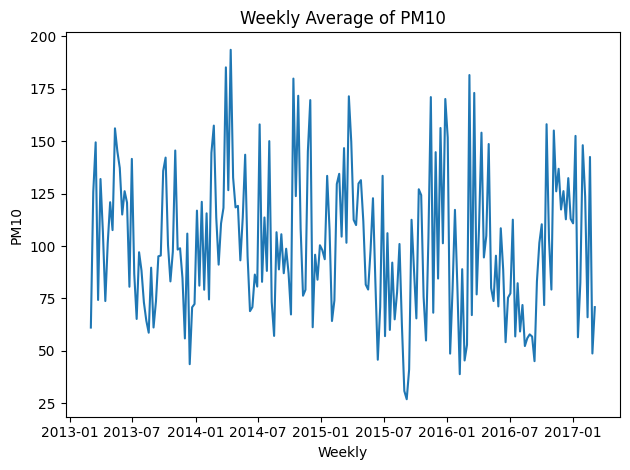

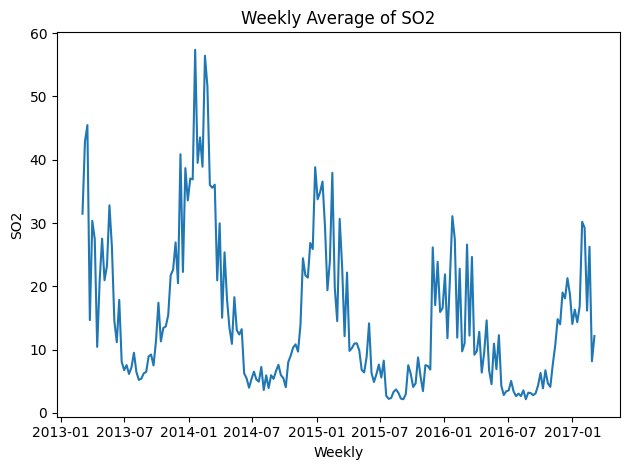

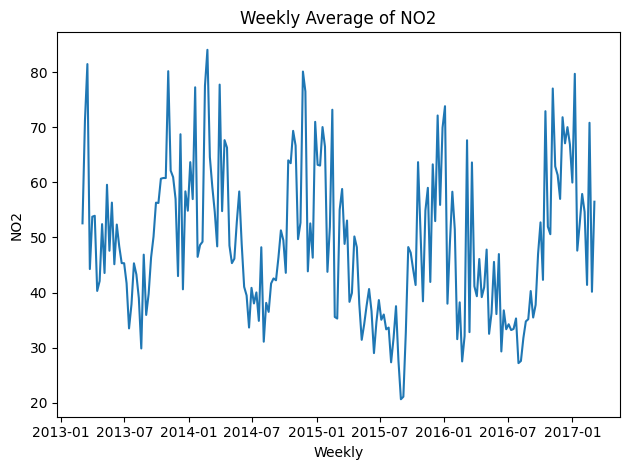

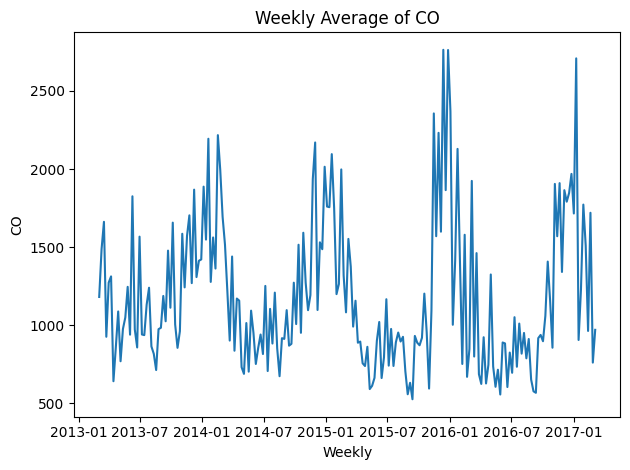

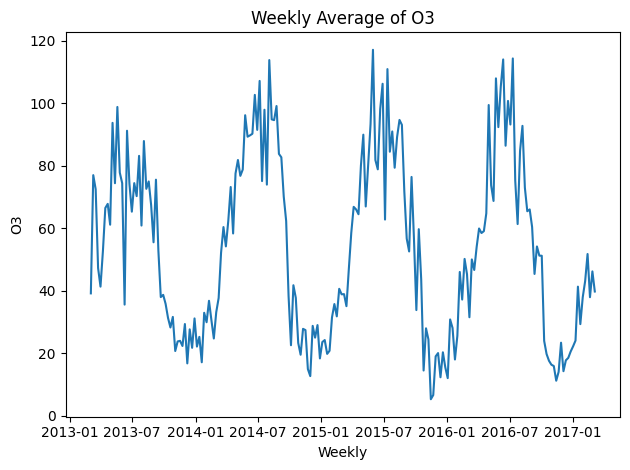

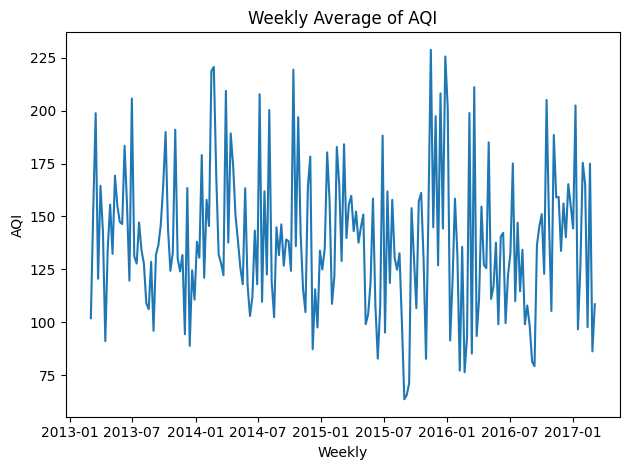

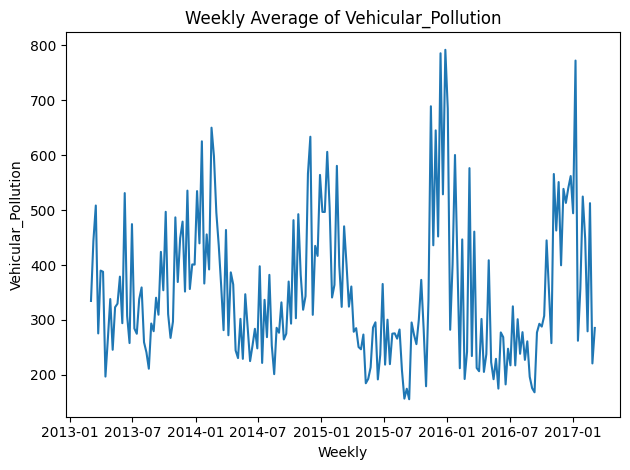

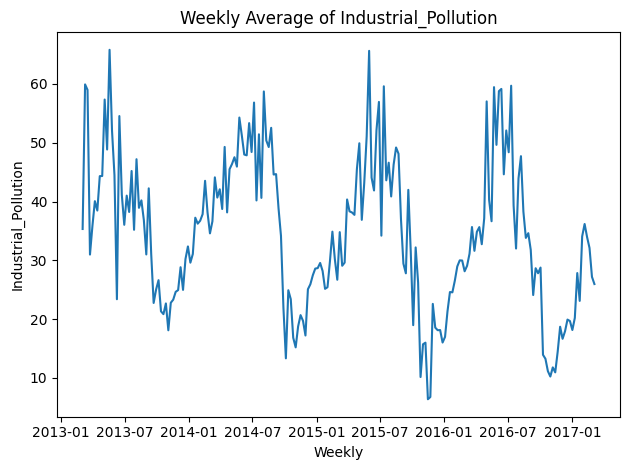

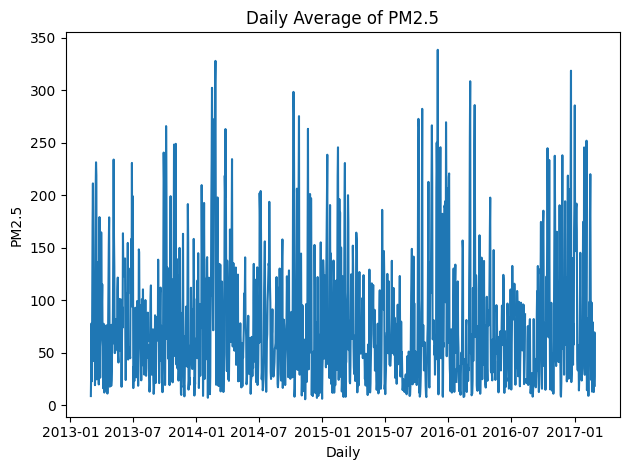

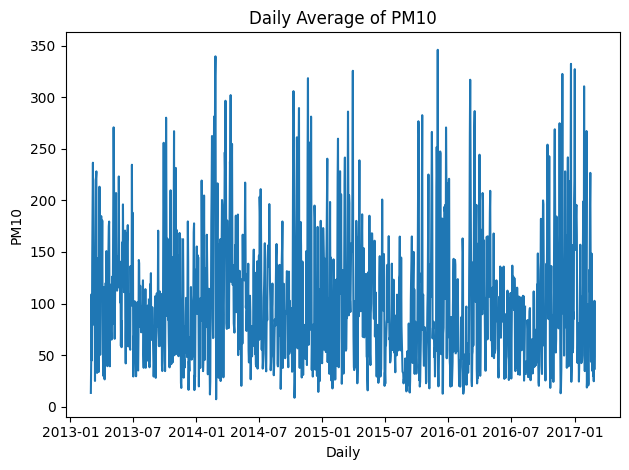

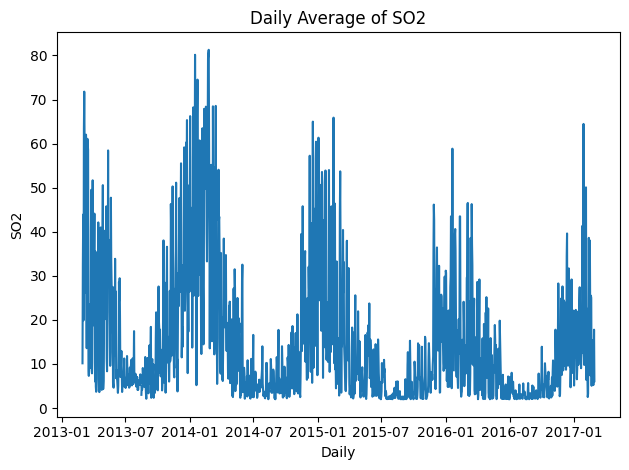

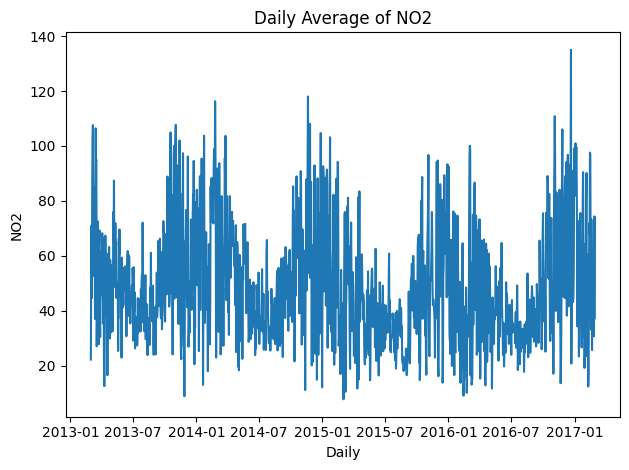

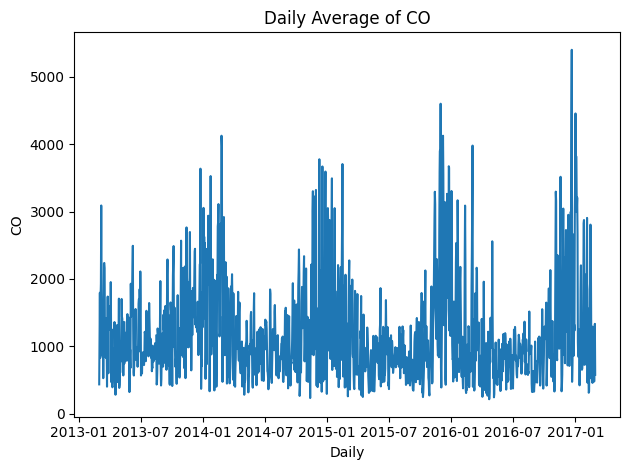

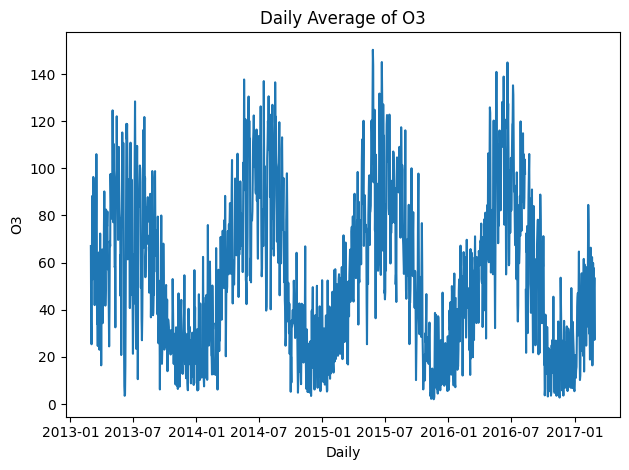

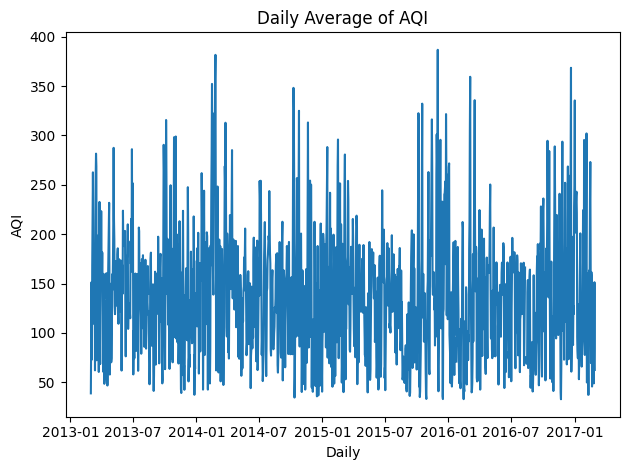

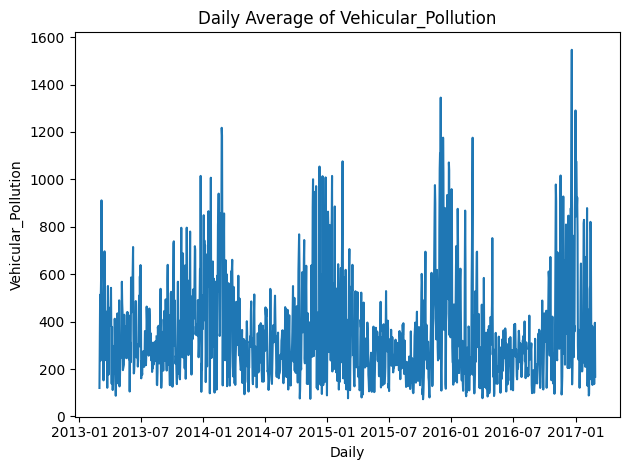

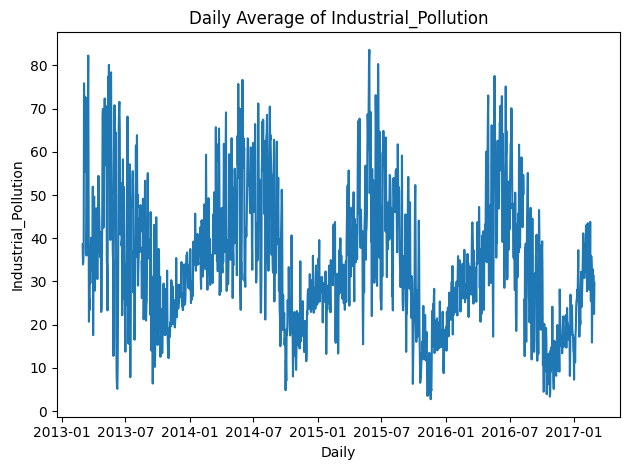

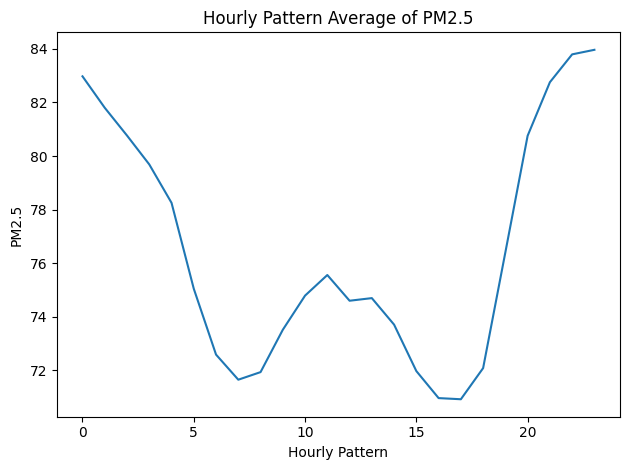

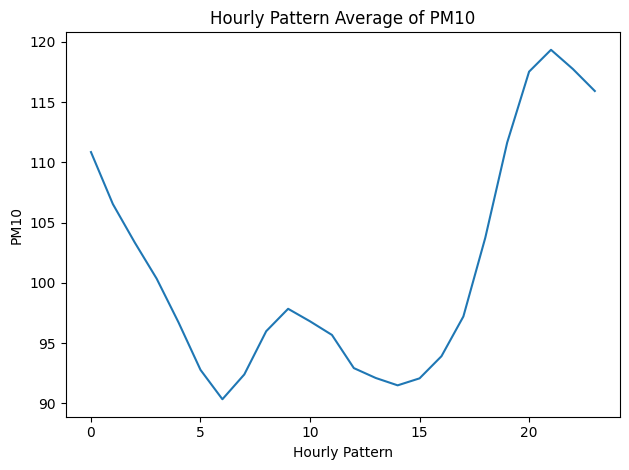

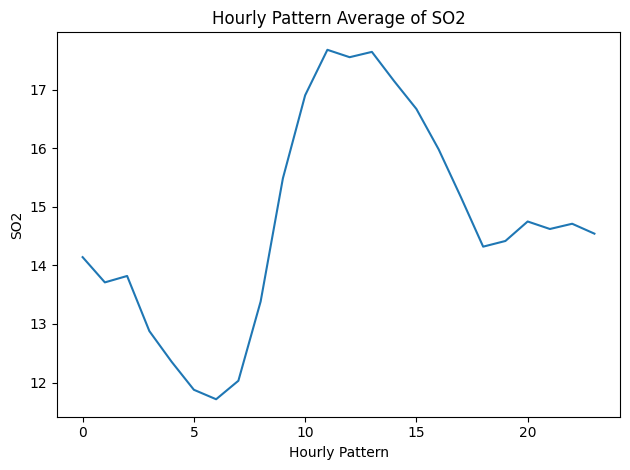

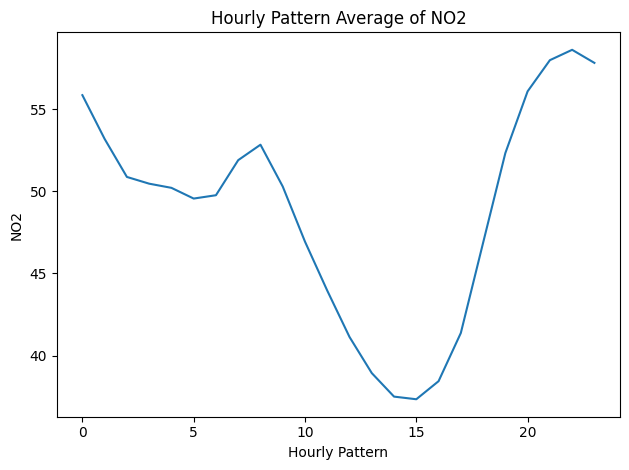

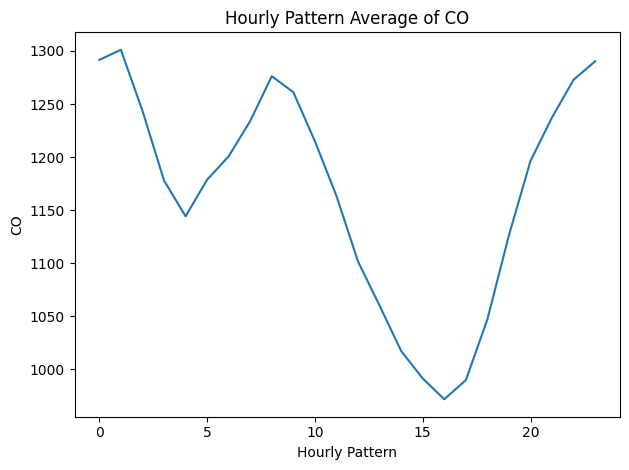

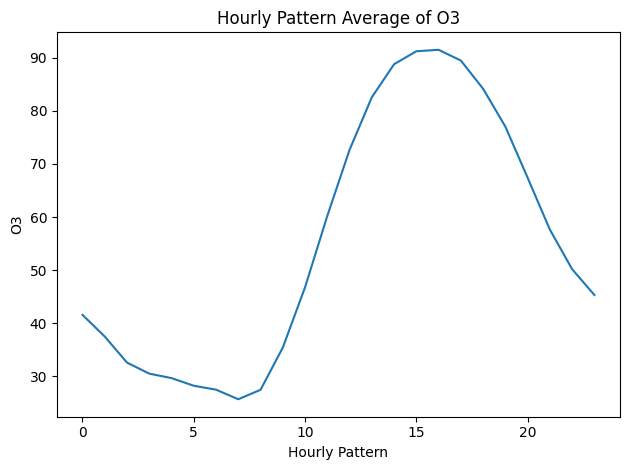

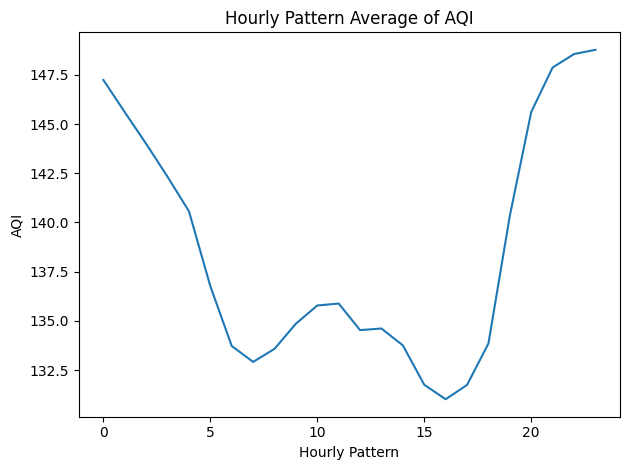

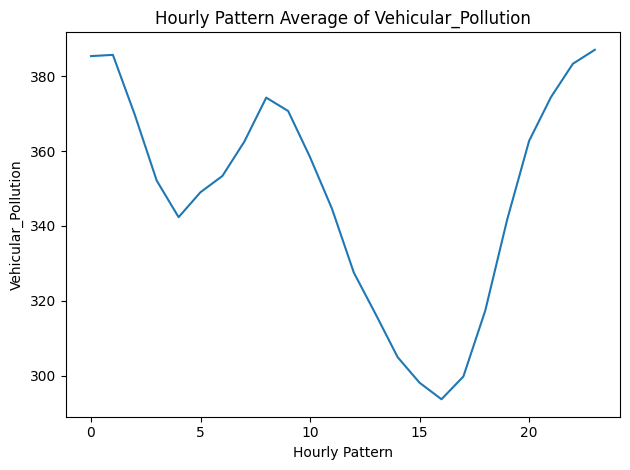

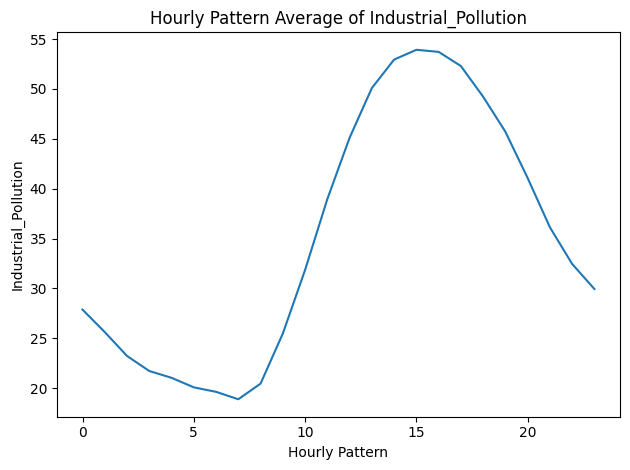

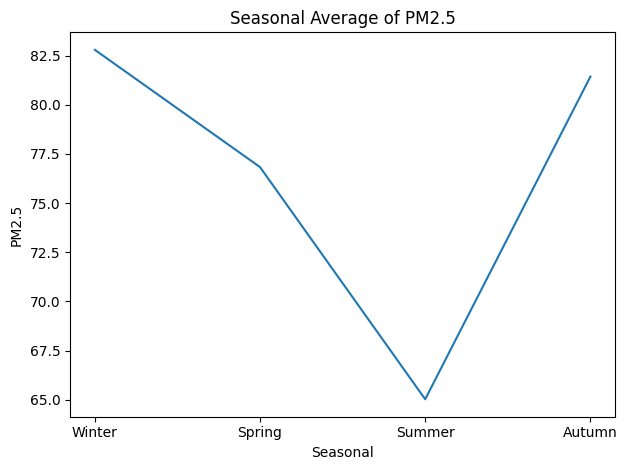

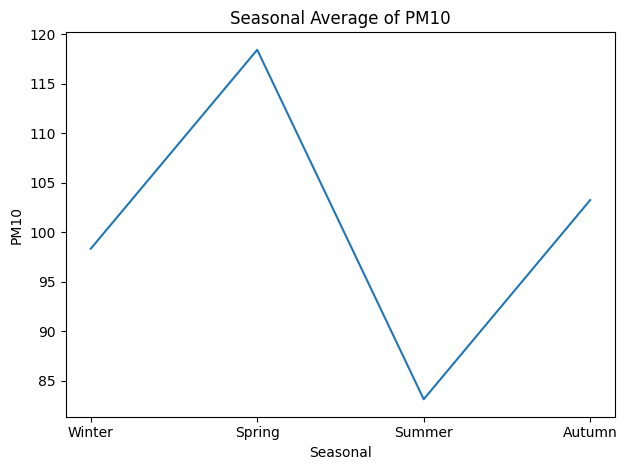

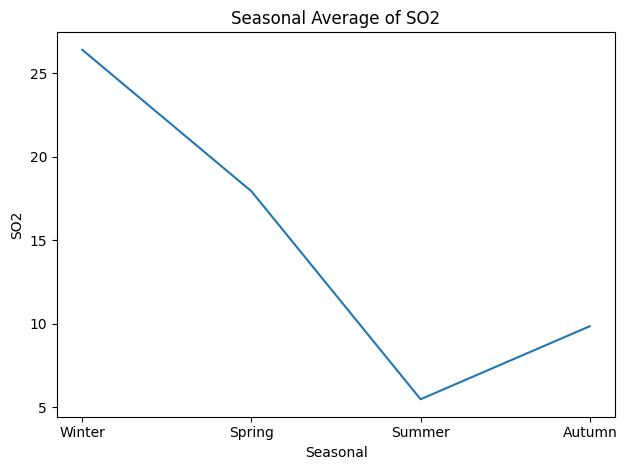

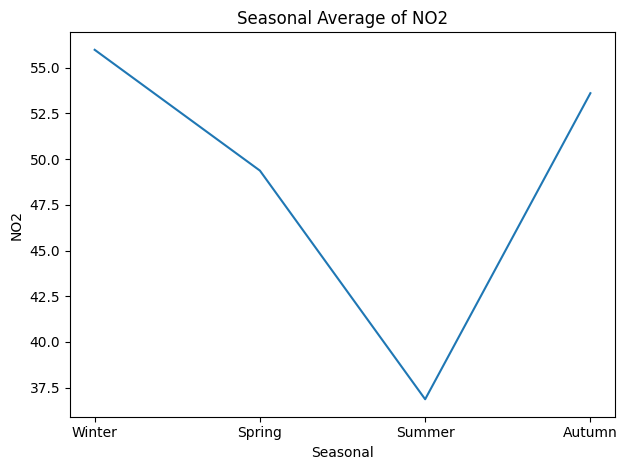

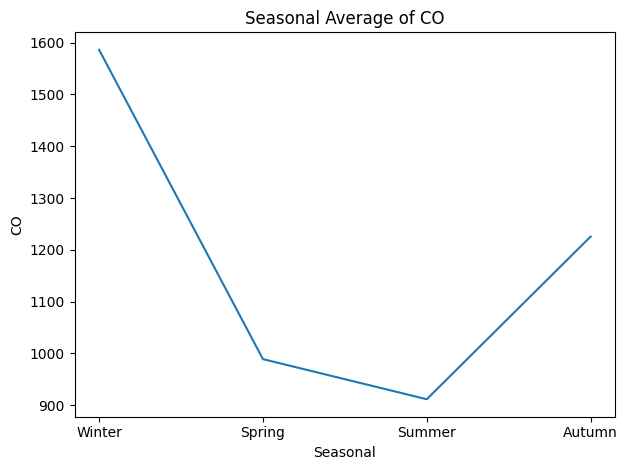

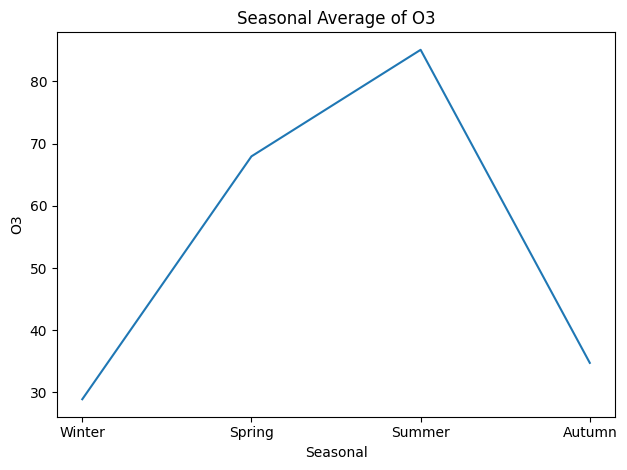

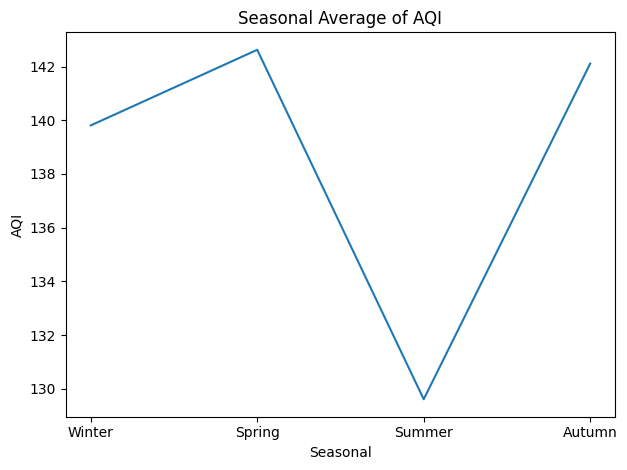

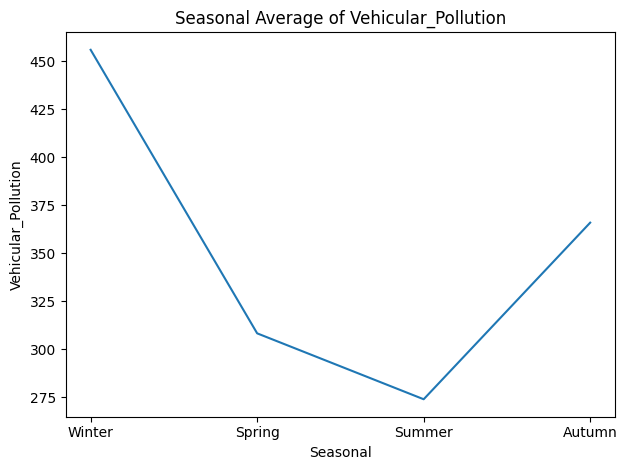

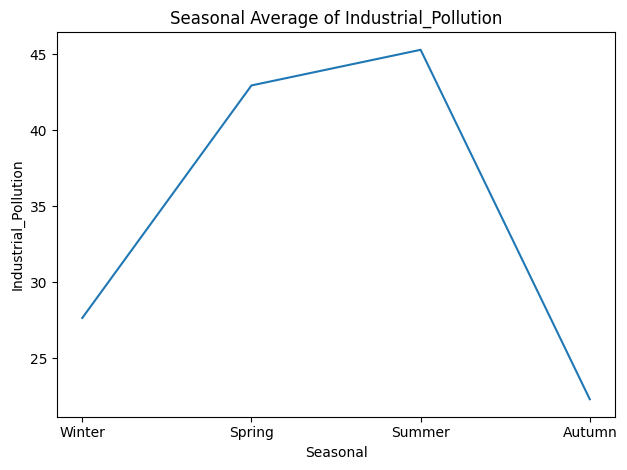

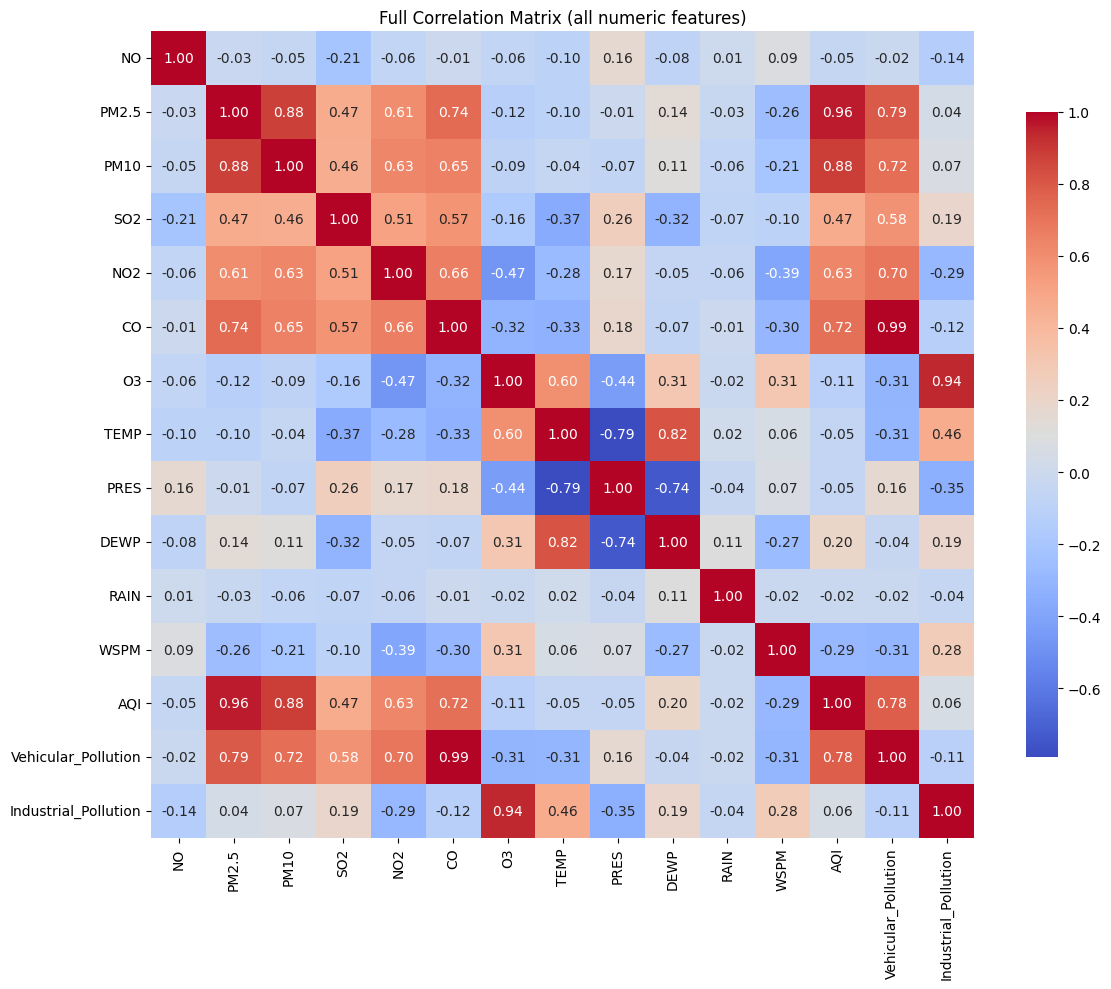

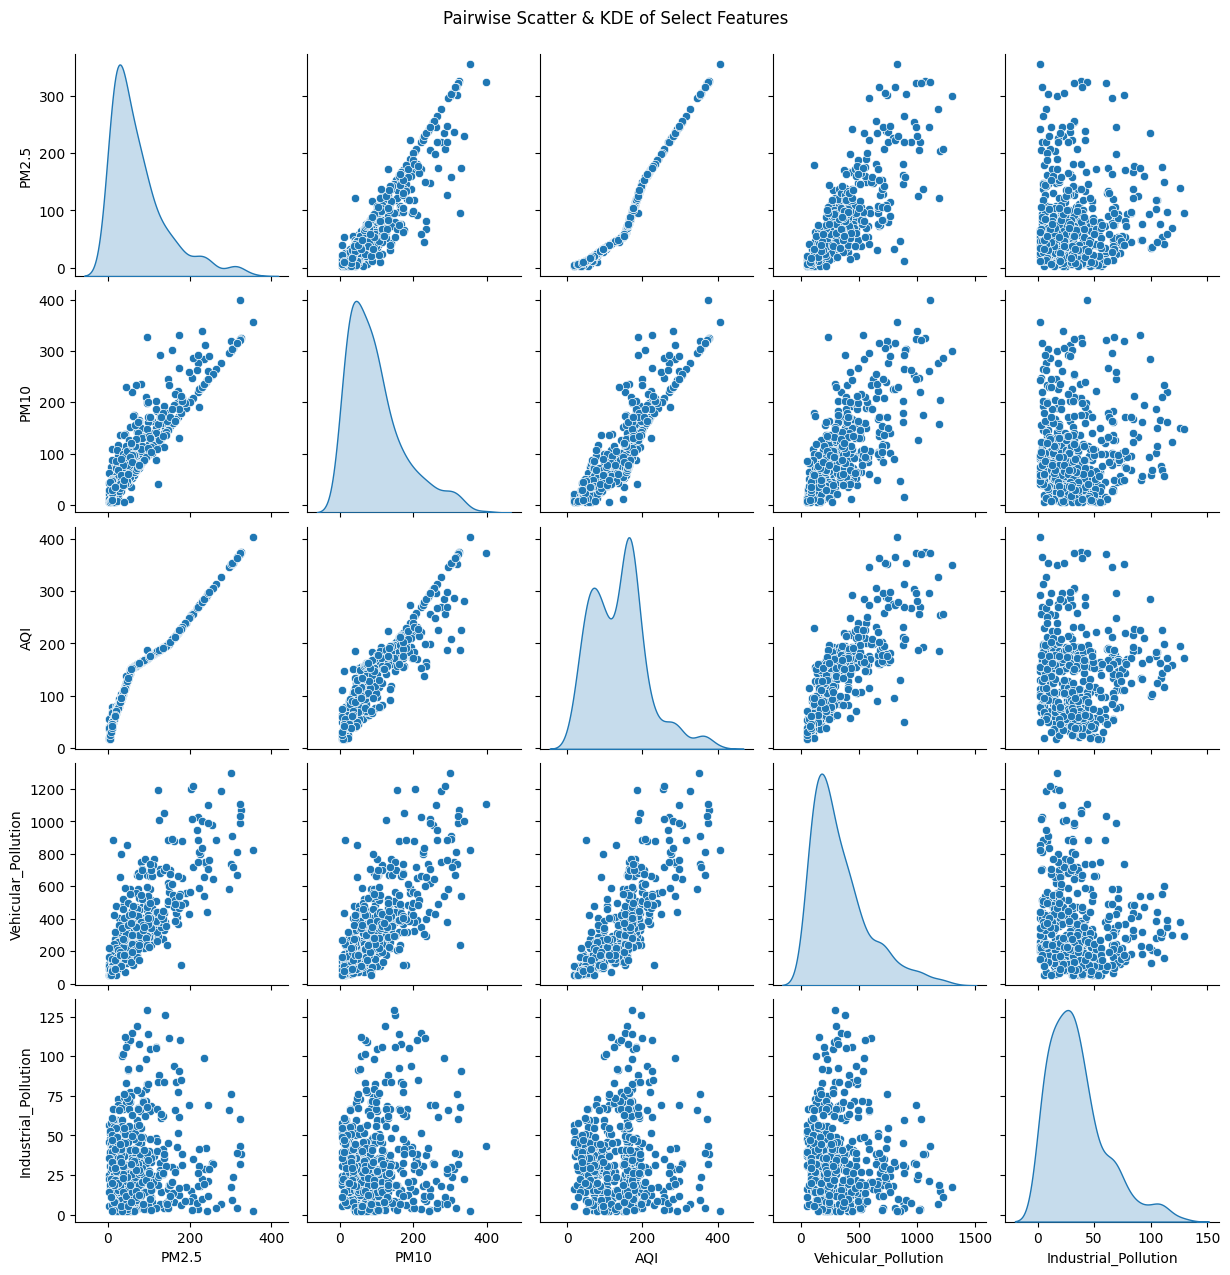

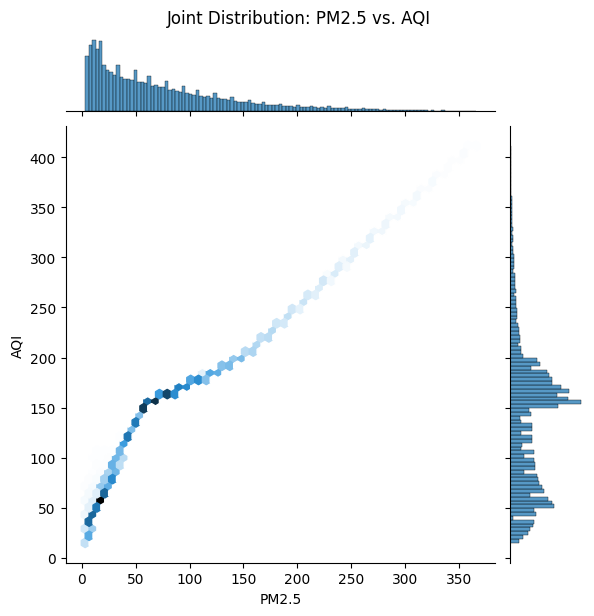

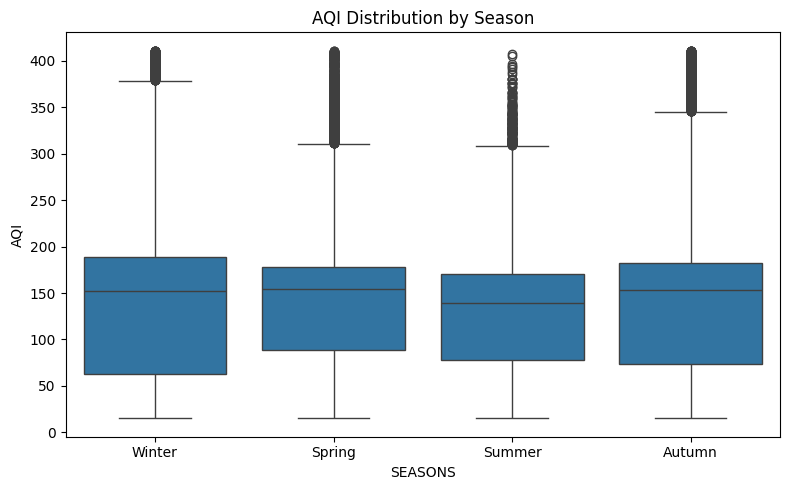

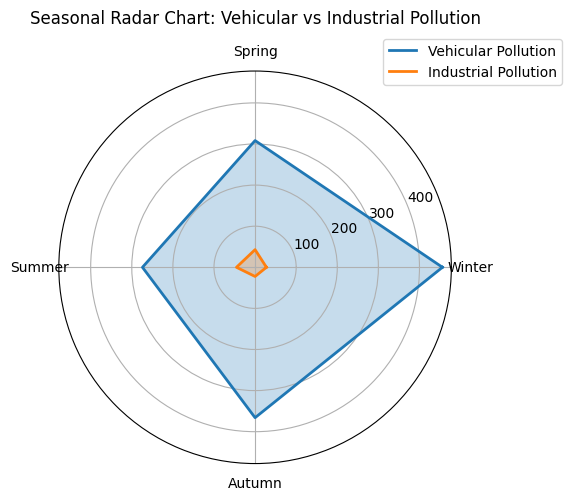

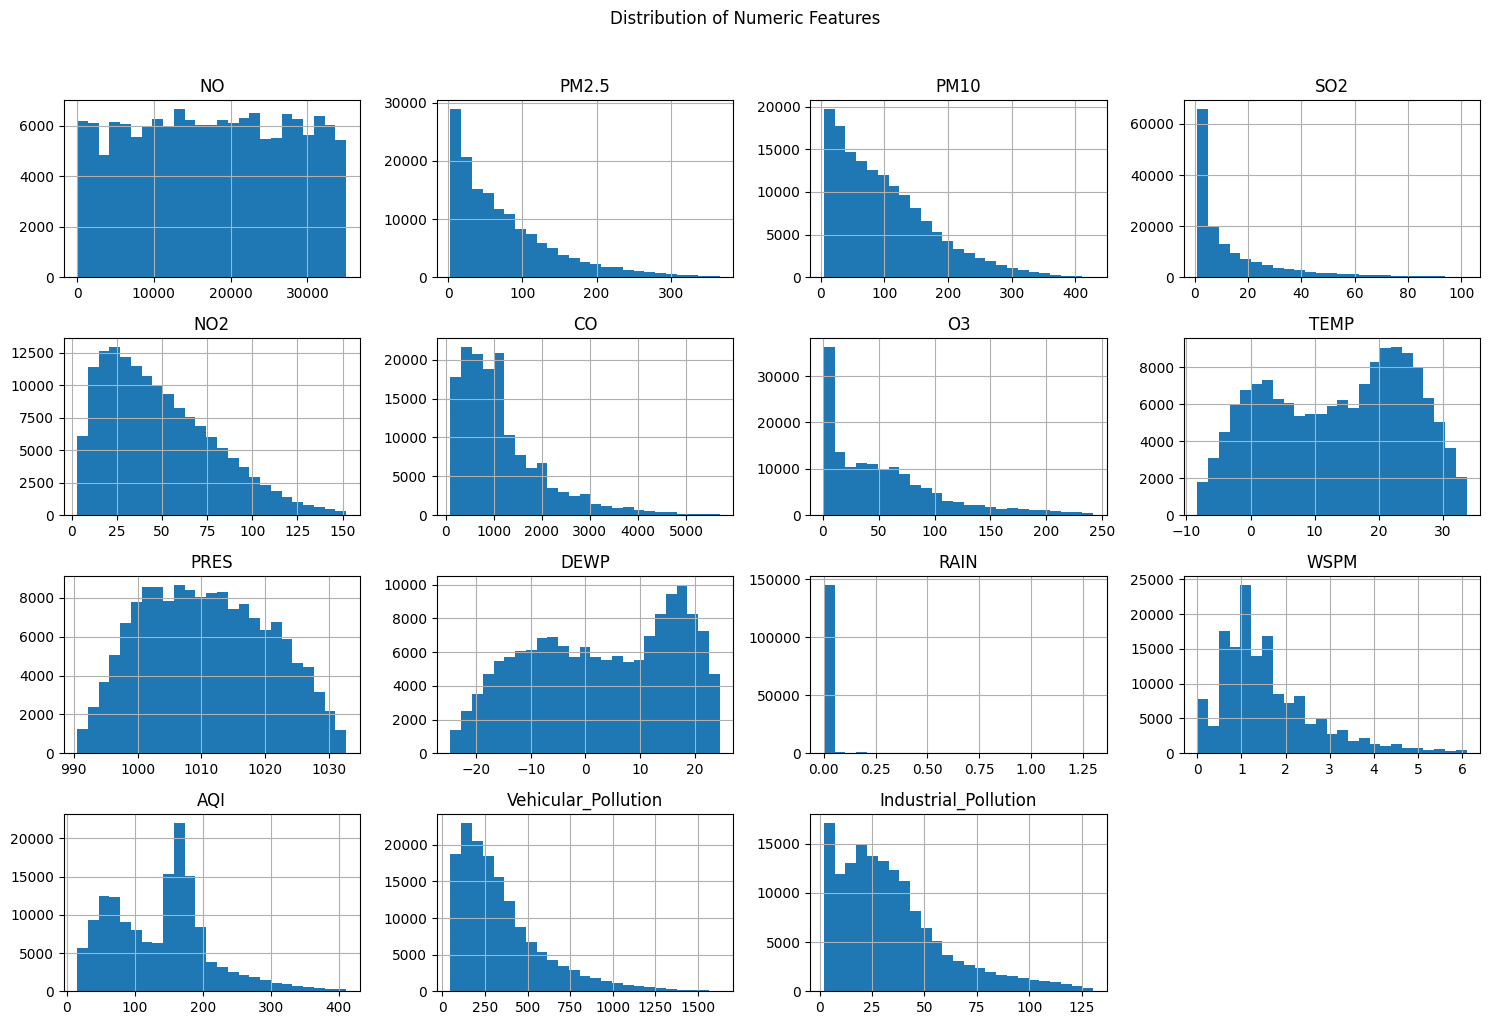

<ipython-input-28-7ad14bd9bf3c>:100: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .groupby([pd.Grouper(freq='M'), 'STATION'])[col]


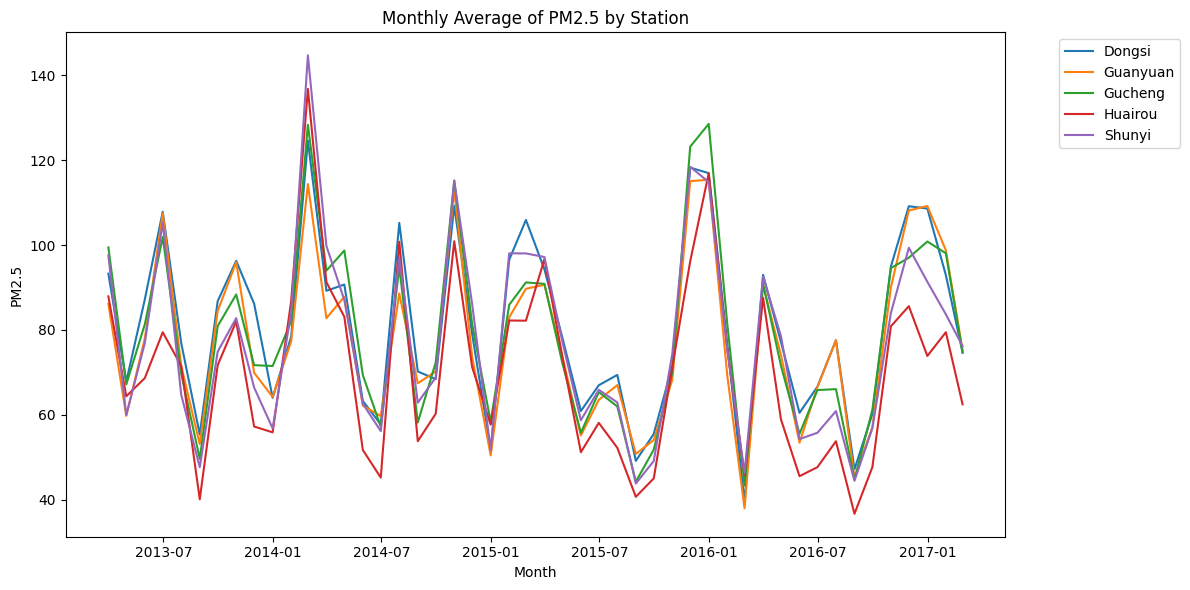

<ipython-input-28-7ad14bd9bf3c>:100: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .groupby([pd.Grouper(freq='M'), 'STATION'])[col]


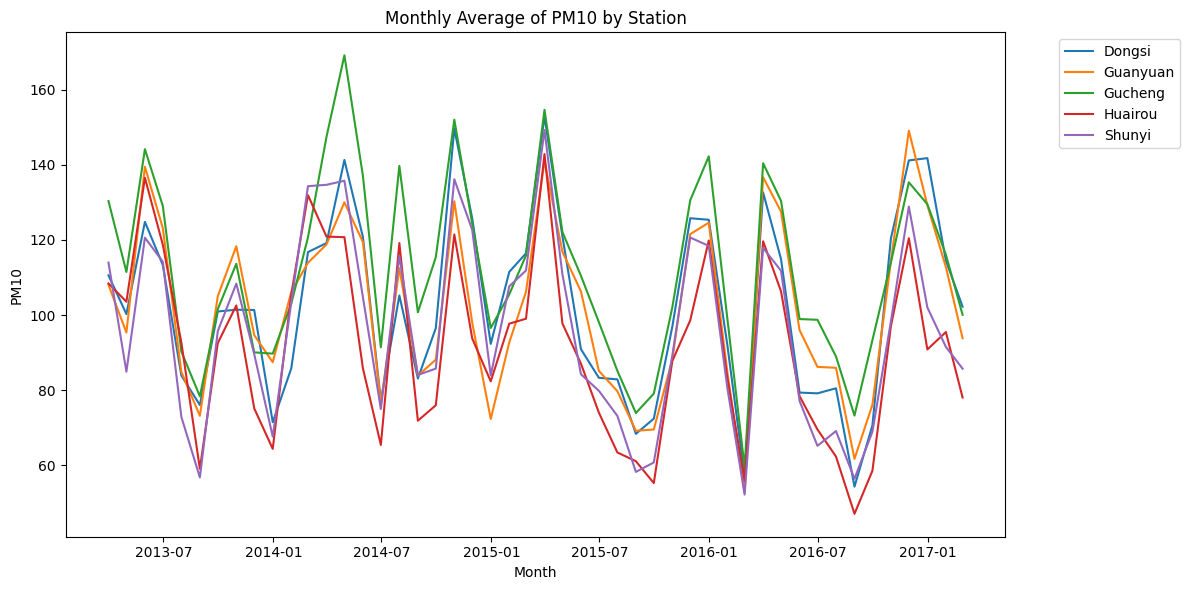

<ipython-input-28-7ad14bd9bf3c>:100: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .groupby([pd.Grouper(freq='M'), 'STATION'])[col]


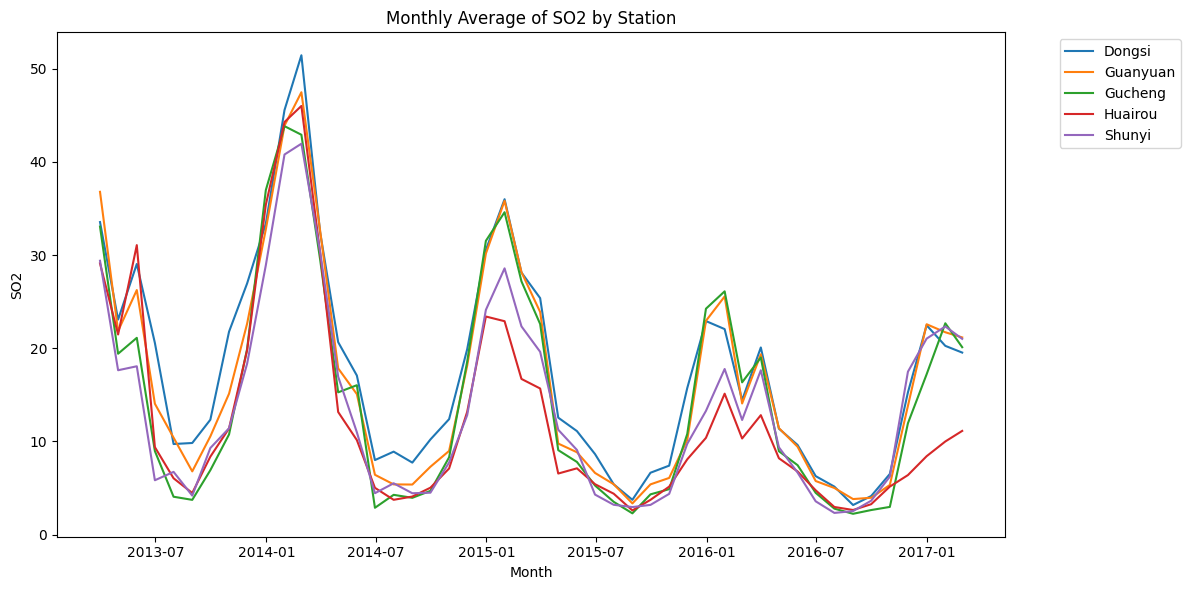

<ipython-input-28-7ad14bd9bf3c>:100: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .groupby([pd.Grouper(freq='M'), 'STATION'])[col]


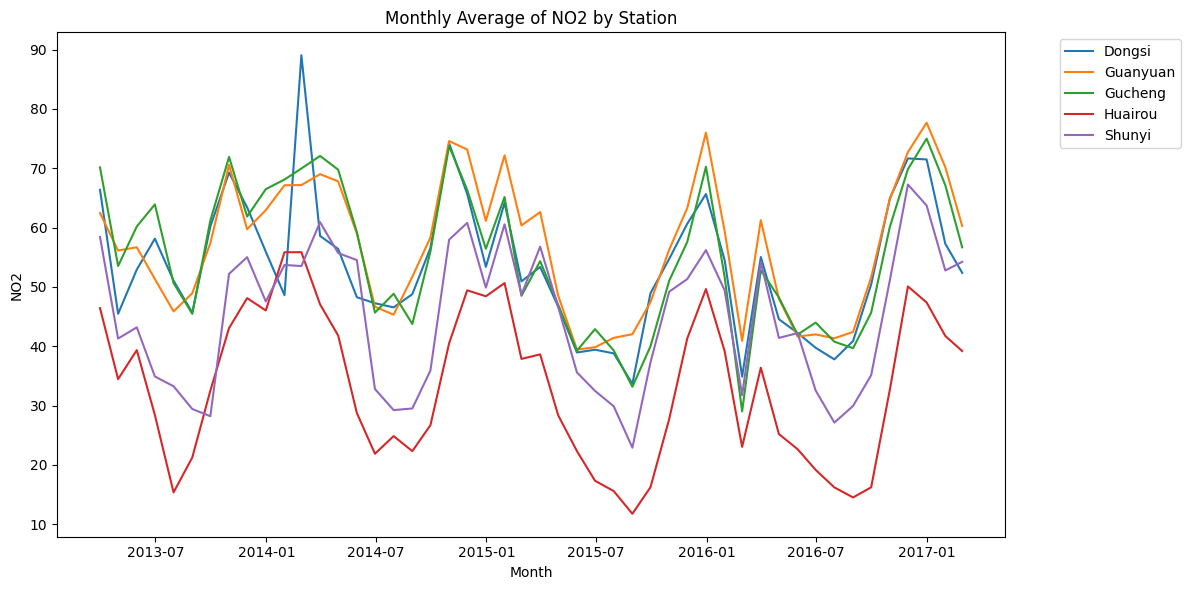

<ipython-input-28-7ad14bd9bf3c>:100: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .groupby([pd.Grouper(freq='M'), 'STATION'])[col]


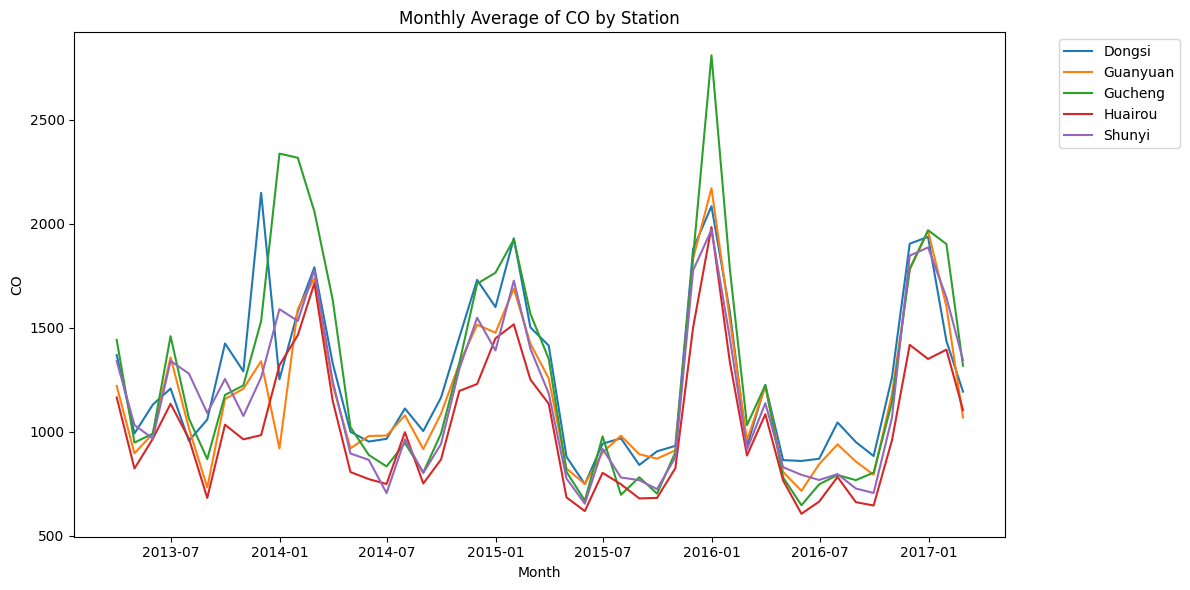

<ipython-input-28-7ad14bd9bf3c>:100: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .groupby([pd.Grouper(freq='M'), 'STATION'])[col]


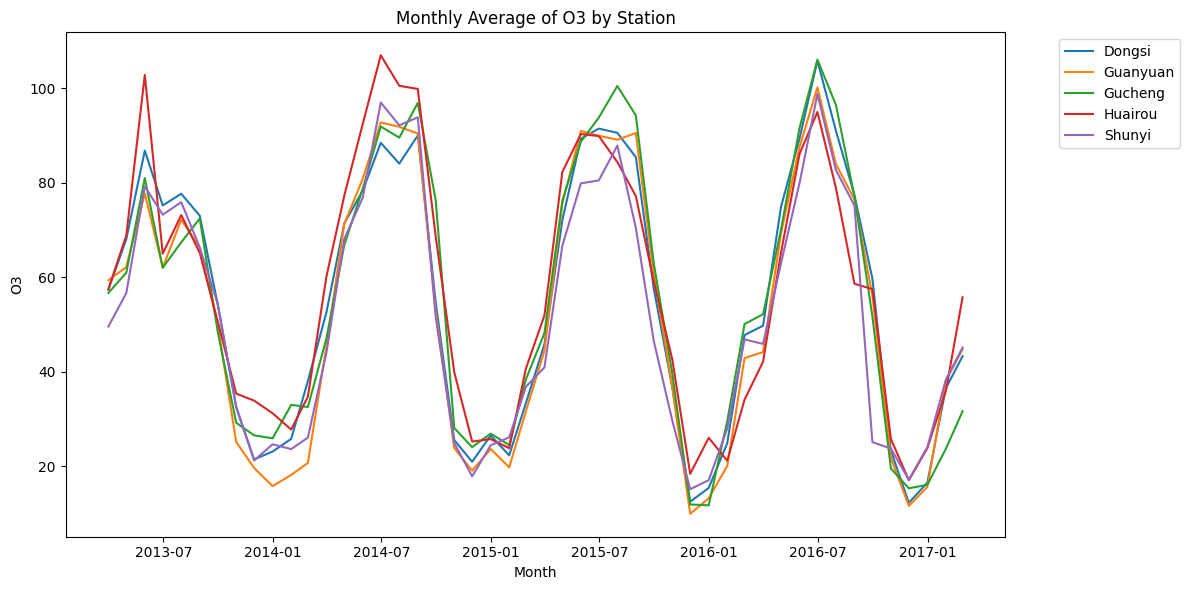

<ipython-input-28-7ad14bd9bf3c>:100: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .groupby([pd.Grouper(freq='M'), 'STATION'])[col]


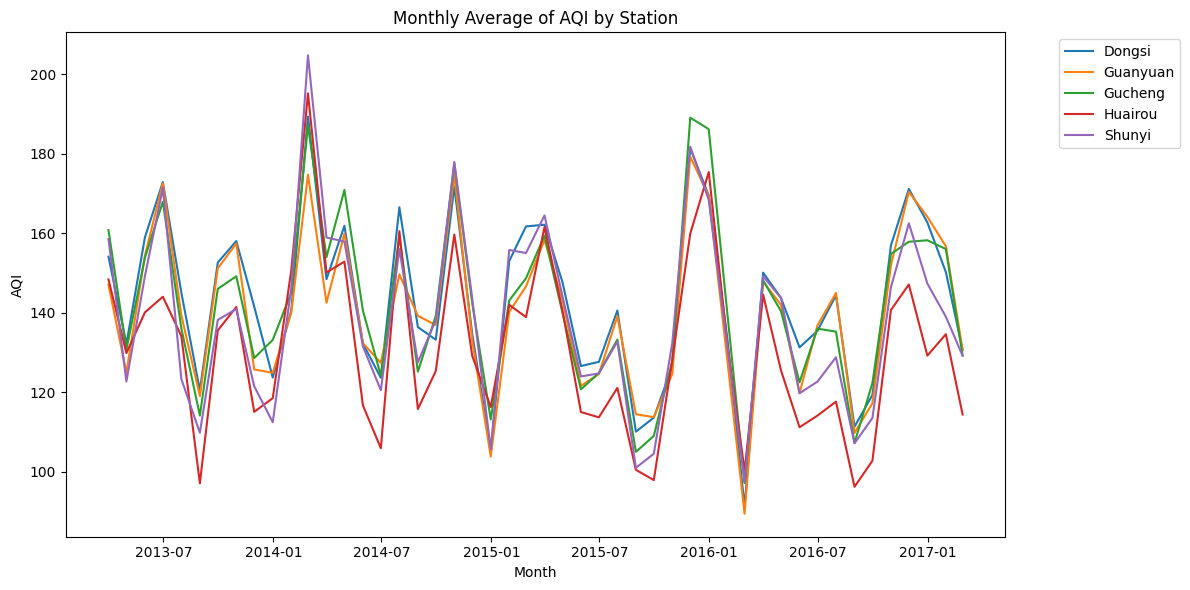

<ipython-input-28-7ad14bd9bf3c>:100: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .groupby([pd.Grouper(freq='M'), 'STATION'])[col]


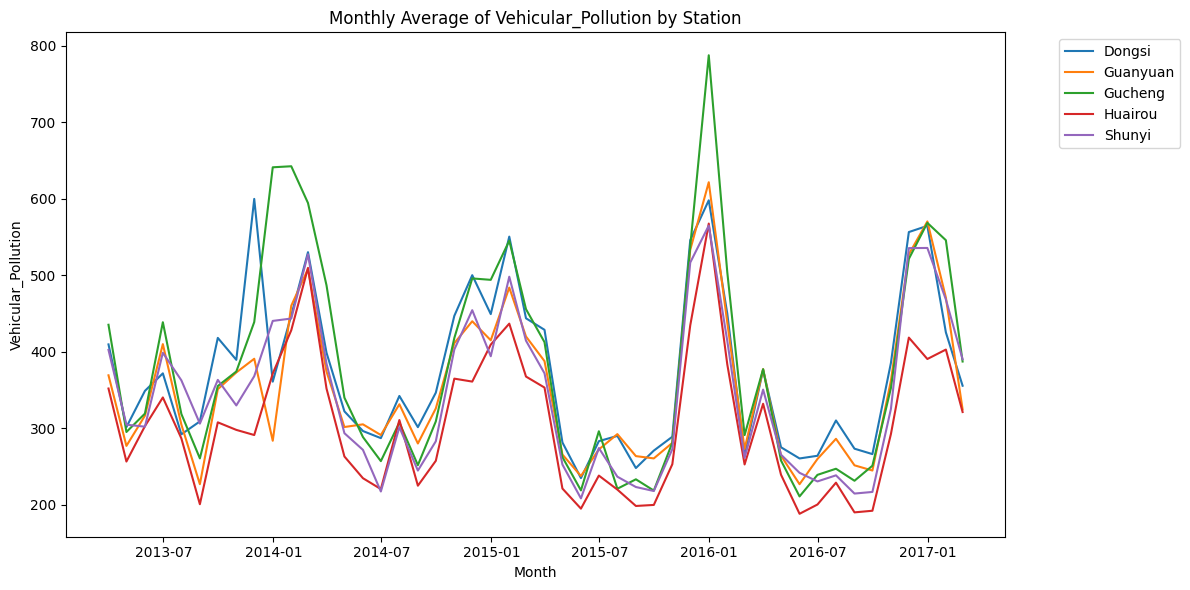

<ipython-input-28-7ad14bd9bf3c>:100: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .groupby([pd.Grouper(freq='M'), 'STATION'])[col]


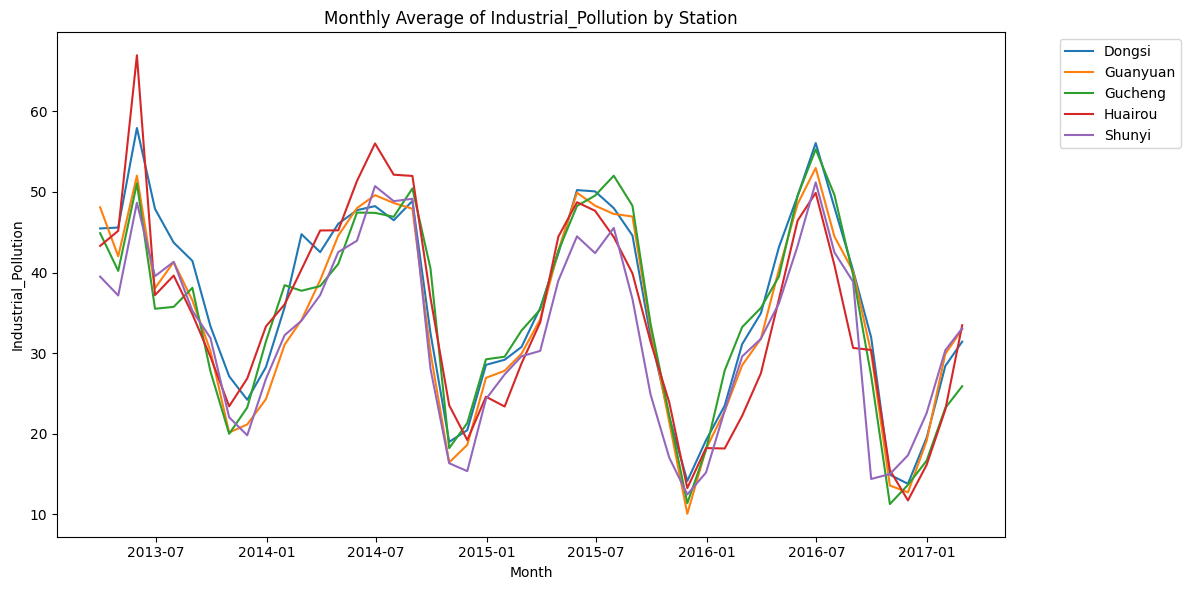

In [28]:
# 1. Loaded the enriched dataset
df = pd.read_csv('merged_data_eda.csv', parse_dates=['DATETIME'], index_col='DATETIME')
display(df.head())

# 2. Recomputed numeric-only time summaries
yearly         = df.resample('YE').mean(numeric_only=True)
monthly        = df.resample('ME').mean(numeric_only=True)
weekly         = df.resample('W').mean(numeric_only=True)
daily          = df.resample('D').mean(numeric_only=True)
hourly_pattern = df.groupby(df.index.hour).mean(numeric_only=True)
seasonal       = df.groupby('SEASONS').mean(numeric_only=True).reindex(['Winter','Spring','Summer','Autumn'])

# 3. Time‐series line plots for each pollutant, AQI, and grouped features
to_plot = [
    'PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'AQI',
    'Vehicular_Pollution', 'Industrial_Pollution'
]
for label, grouping in [
    ('Yearly', yearly),
    ('Monthly', monthly),
    ('Weekly', weekly),
    ('Daily', daily),
    ('Hourly Pattern', hourly_pattern),
    ('Seasonal', seasonal)
]:
    for col in to_plot:
        plt.figure()
        plt.plot(grouping.index, grouping[col])
        plt.title(f'{label} Average of {col}')
        plt.xlabel(label)
        plt.ylabel(col)
        plt.tight_layout()
        plt.show()

# 4. Full correlation matrix (excluding ‘No’)
numeric_cols = df.select_dtypes(include='number').columns.drop(['No'], errors='ignore')
corr_full = df[numeric_cols].corr()
corr_full.to_csv('full_correlation_matrix.csv')

plt.figure(figsize=(12,10))
sns.heatmap(corr_full, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'shrink': .8})
plt.title("Full Correlation Matrix (all numeric features)")
plt.tight_layout()
plt.show()

# 5. Pairplot for key relationships
sample = df[['PM2.5','PM10','AQI','Vehicular_Pollution','Industrial_Pollution']].sample(500, random_state=42)
sns.pairplot(sample, diag_kind='kde')
plt.suptitle("Pairwise Scatter & KDE of Select Features", y=1.02)
plt.show()

# 6. Joint plot for highest‐correlated pair (PM2.5 vs AQI)
sns.jointplot(x='PM2.5', y='AQI', data=df, kind='hex', height=6)
plt.suptitle("Joint Distribution: PM2.5 vs. AQI", y=1.02)
plt.show()

# 7. Boxplot of AQI by season
plt.figure(figsize=(8,5))
sns.boxplot(x='SEASONS', y='AQI', data=df, order=['Winter','Spring','Summer','Autumn'])
plt.title("AQI Distribution by Season")
plt.tight_layout()
plt.show()

# 8. Star chart of Vehicular vs Industrial Pollution
easonal = df.groupby('SEASONS').mean(numeric_only=True).reindex(
    ['Winter','Spring','Summer','Autumn']
)
veh = seasonal['Vehicular_Pollution'].values
ind = seasonal['Industrial_Pollution'].values
seasons = seasonal.index.tolist()
# radar chart angles
angles = np.linspace(0, 2 * np.pi, len(seasons), endpoint=False).tolist()
angles += angles[:1]  # close the loop
# Close the values
veh_values = veh.tolist() + veh[:1].tolist()
ind_values = ind.tolist() + ind[:1].tolist()
# Start plot
fig, ax = plt.subplots(figsize=(6,6), subplot_kw=dict(polar=True))
ax.plot(angles, veh_values, label='Vehicular Pollution', linewidth=2)
ax.fill(angles, veh_values, alpha=0.25)
ax.plot(angles, ind_values, label='Industrial Pollution', linewidth=2)
ax.fill(angles, ind_values, alpha=0.25)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(seasons)
plt.title("Seasonal Radar Chart: Vehicular vs Industrial Pollution", y=1.1)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()

# 9. Histograms of all numeric features
df[numeric_cols].hist(bins=25, figsize=(15,10))
plt.suptitle("Distribution of Numeric Features", y=1.02)
plt.tight_layout()
plt.show()

# 10. Monthly time series of each feature by station
for col in to_plot:
    monthly_station = (
        df
        .groupby([pd.Grouper(freq='M'), 'STATION'])[col]
        .mean()
        .reset_index()
    )
    plt.figure(figsize=(12,6))
    sns.lineplot(
        data=monthly_station,
        x='DATETIME', y=col,
        hue='STATION', legend='full',
        palette='tab10'
    )
    plt.title(f"Monthly Average of {col} by Station")
    plt.xlabel("Month")
    plt.ylabel(col)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1)
    plt.tight_layout()
    plt.show()


## Task 03: Model Building


#### Loading data and Encoding Special Columns

In [ ]:
df = pd.read_csv('merged_data_eda.csv', parse_dates=['DATETIME'], index_col='DATETIME')
display(df.head())

# Encode categorical columns
for col in ['WD','STATION','AQI_Category','SEASONS']:
    mapping = {v:i for i,v in enumerate(sorted(df[col].unique()))}
    df[col + '_code'] = df[col].map(mapping)


NO  PM2.5  PM10   SO2   NO2      CO    O3  TEMP    PRES  \
DATETIME                                                                       
2013-03-01 20:00:00  21   13.0  25.0  12.0   5.0  1100.0  61.0   1.6  1027.1   
2013-03-01 21:00:00  22   15.0  23.0  14.0  13.0  1200.0  52.0   1.0  1028.1   
2013-03-01 22:00:00  23   16.0  28.0  16.0  19.0  1200.0  45.0   1.3  1028.4   
2013-03-01 23:00:00  24   16.0  28.0  14.0  20.0  1100.0  44.0   0.2  1028.6   
2013-03-02 00:00:00  25   14.0  18.0  24.0  43.0  1399.0  25.0  -0.3  1028.9   

                     DEWP  RAIN   WD  WSPM  STATION  AQI AQI_Category  \
DATETIME                                                                
2013-03-01 20:00:00 -18.4   0.0  ESE   1.9  Gucheng   53     Moderate   
2013-03-01 21:00:00 -17.4   0.0  SSE   0.7  Gucheng   57     Moderate   
2013-03-01 22:00:00 -17.6   0.0    E   1.0  Gucheng   59     Moderate   
2013-03-01 23:00:00 -17.6   0.0  ESE   1.1  Gucheng   59     Moderate   
2013-03-02 00:00:00 -18.0   0.0  ENE   1.4  Gucheng   55     Moderate   

                     Vehicular_Pollution  Industrial_Pollution SEASONS  
DATETIME                                                                
2013-03-01 20:00:00               285.75                  36.5  Spring  
2013-03-01 21:00:00               312.75                  33.0  Spring  
2013-03-01 22:00:00               315.75                  30.5  Spring  
2013-03-01 23:00:00               291.00                  29.0  Spring  
2013-03-02 00:00:00               368.50                  24.5  Spring

#### Train/Test Split, Scaling & Feature Selection

In [ ]:
# Features and target
y = df['AQI'].values
X = df.drop(columns=['AQI','WD','STATION','AQI_Category','SEASONS','NO'])

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s  = scaler.transform(X_test)
joblib.dump(scaler, 'scaler.pkl')

# Select top-10 features
selector = SelectKBest(f_regression, k=10).fit(X_train_s, y_train)
X_train_sel = selector.transform(X_train_s)
X_test_sel  = selector.transform(X_test_s)
joblib.dump(selector, 'selector.pkl')

['selector.pkl']

#### Hyperparameter Grids & Model Training

In [ ]:
# Define models + parameter grids
param_grids = {
    'Ridge': {
        'model': Ridge(),
        'params': {'alpha': [0.1, 1.0, 10.0]}
    },
    'DecisionTree': {
        'model': DecisionTreeRegressor(random_state=42),
        'params': {'max_depth': [5,10], 'min_samples_leaf': [5,10]}
    },
    'RandomForest': {
        'model': RandomForestRegressor(random_state=42),
        'params': {'n_estimators': [50,100], 'max_depth': [10,20], 'min_samples_leaf': [5]}
    },
    'GradientBoosting': {
        'model': GradientBoostingRegressor(random_state=42),
        'params': {'n_estimators': [50,100], 'learning_rate': [0.01,0.1], 'max_depth': [3,5]}
    },
    'SVR': {
        'model': SVR(),
        'params': {'C': [0.1,1.0], 'epsilon': [0.1,0.5], 'kernel': ['rbf']}
    },
    'KNeighbors': {
        'model': KNeighborsRegressor(),
        'params': {'n_neighbors': [3,5,7]}
    }
}

results = {}
predictions = pd.DataFrame({'Actual': y_test})

# GridSearch, train, predict, save
for name, mp in param_grids.items():
    gs = GridSearchCV(
        mp['model'], mp['params'],
        cv=5, scoring='r2', n_jobs=-1
    )
    t0 = time.time()
    gs.fit(X_train_sel, y_train)
    train_time = time.time() - t0

    best = gs.best_estimator_
    y_pred = best.predict(X_test_sel)
    predictions[name + '_Pred'] = y_pred
    joblib.dump(best, f'{name}_best.pkl')

    mse  = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred) * 100
    r2   = r2_score(y_test, y_pred)

    results[name] = {
        'Train_Time_s': train_time,
        'R2': r2,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE_%': mape
    }

# Persist
results_df = pd.DataFrame(results).T
results_df.to_csv('model_performance_tuned.csv')
predictions.to_csv('model_predictions_tuned.csv', index=False)

display(results_df)

Train_Time_s        R2       RMSE        MAE     MAPE_%
Ridge                 5.052880  0.952252  15.773193  13.051323  13.450325
DecisionTree          7.393019  0.999787   1.053791   0.262937   0.452143
RandomForest        606.729584  0.999884   0.776133   0.059120   0.058176
GradientBoosting    705.579266  0.999945   0.536639   0.180748   0.264282
SVR               19015.597044  0.990391   7.076016   3.990198   4.546769
KNeighbors           68.547171  0.987131   8.188699   5.990074   7.035589

#### Plotting: Predicted vs Actual & Error Comparison

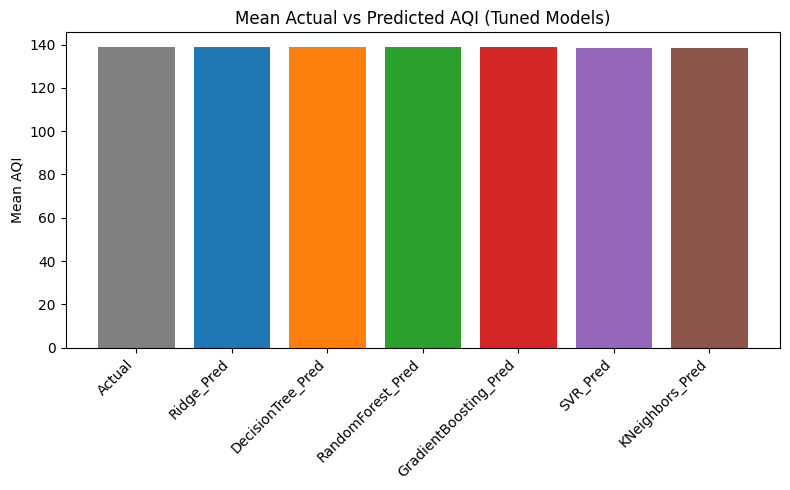

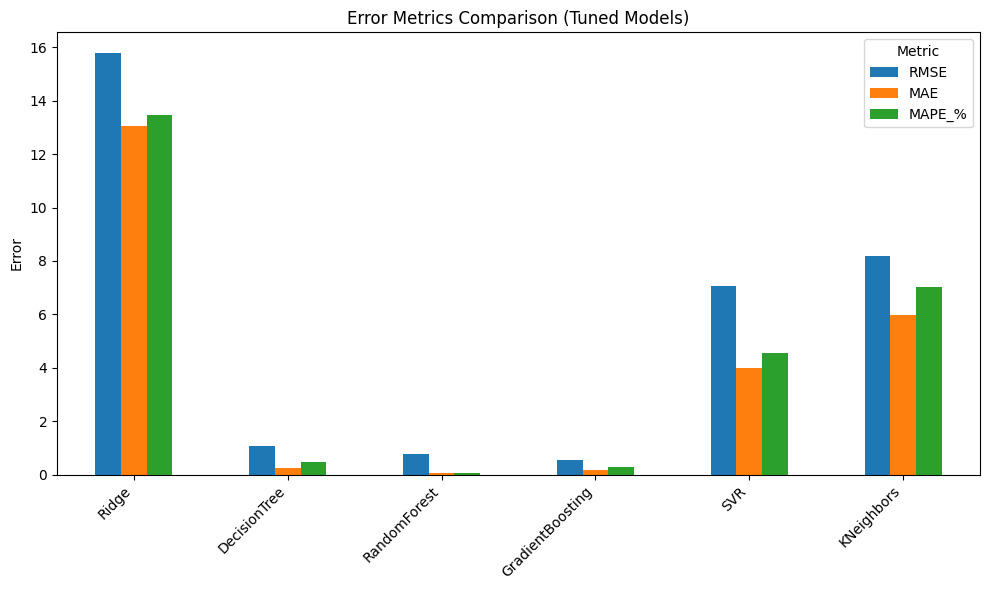

In [ ]:
# Bar: Mean Actual vs Predicted
mean_actual = predictions['Actual'].mean()
mean_preds  = predictions.drop(columns='Actual').mean()

plt.figure(figsize=(8,5))
plt.bar(
    ['Actual'] + list(mean_preds.index),
    [mean_actual] + list(mean_preds.values),
    color=['gray'] + [f'C{i}' for i in range(len(mean_preds))]
)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Mean AQI')
plt.title('Mean Actual vs Predicted AQI (Tuned Models)')
plt.tight_layout()
plt.show()

# Bar: Error comparison
errors = results_df[['RMSE','MAE','MAPE_%']]
errors.plot(kind='bar', figsize=(10,6))
plt.title('Error Metrics Comparison (Tuned Models)')
plt.ylabel('Error')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

In [39]:
from google.colab import output

# 1) Launch Streamlit in the background
get_ipython().system_raw("streamlit run app.py --server.port 8501 &")

# 2) Embed the running app inline
output.serve_kernel_port_as_iframe(8501, height=800)
!streamlit run app.py



<IPython.core.display.Javascript object>




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8502
  Network URL: http://172.28.0.12:8502
  External URL: http://34.169.112.30:8502

  Stopping...
^C
